In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
#mpl.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pandas as pd
import os
import datetime
#import seaborn as sns
import timeit
import random
from dask.diagnostics import ProgressBar
from functools import partial
import dask

from scipy import ndimage

In [2]:
#setting progress bar visible
ProgressBar().register()
#making sure that xarray/dask splits large chunks while reading in data
dask.config.set({"array.slicing.split_large_chunks": True})

In [3]:
#%automagic

In [4]:
#%% plot parameters
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally
plt.rc('font', family='serif',size = 18)  # controls default text layout
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

#sns.set()

plt.rc('text', usetex=False)


In [5]:
def _subset_process_time(ds,var,iop):
    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02':ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03':ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)

#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
            if iop=='iop03': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','u','v','wtheta','wq']
            partial_func = partial(_subset_process_time, var=var,iop=iop)
            ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
            ds.close() 
            print('Member',str(member_num),'finished collecting data')    
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)

def calculate_turb_flux(ds):
    #subset for the variable(s)
    ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

    ds['wtheta_turb'] = ds['wtheta'] - ds.w*ds.theta_interpolated
    ds['wq_turb'] = ds['wq'] - ds.w*ds.q_interpolated


    ds['wtheta_turb_energy'] = ds['wtheta_turb']*1.17*1005
    ds['wq_turb_energy'] = ds['wq_turb']*1.17*1000*2501

    return ds


In [6]:
def calc_disp_flux(ds):

    ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

    w_disp = ds['w'] - ds['w'].mean('x').mean('y')

    theta_disp = ds['theta_interpolated'] - ds['theta_interpolated'].mean('x').mean('y')
    q_disp = ds['q_interpolated'] - ds['q_interpolated'].mean('x').mean('y')

    wtheta_disp = (w_disp * theta_disp).mean('x').mean('y').compute()*(1.17*1005)
    wq_disp = (w_disp * q_disp).mean('x').mean('y').compute()*(1.17*1000*2501)
    
    return wtheta_disp, wq_disp


In [7]:
def calc_hzntl_disp_flux(ds,var):

    ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

    if var == 'u': var_disp = (ds['u'] - ds['u'].mean('xu').mean('y')).rename({'xu': 'x','zu_3d': 'zw_3d'}).interp_like(ds.w)
    if var == 'v': var_disp = (ds['v'] - ds['v'].mean('x').mean('yv')).rename({'yv': 'y','zu_3d': 'zw_3d'}).interp_like(ds.w)

    theta_disp = ds['theta_interpolated'] - ds['theta_interpolated'].mean('x').mean('y')
    q_disp = ds['q_interpolated'] - ds['q_interpolated'].mean('x').mean('y')

    vartheta_disp = (var_disp * theta_disp).mean('x').mean('y').compute()*(1.17*1005)
    varq_disp = (var_disp * q_disp).mean('x').mean('y').compute()*(1.17*1000*2501)
    
    return vartheta_disp, varq_disp


In [8]:
def _subset_process_time_hom(ds,var,iop):    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if ds.time.dtype == '<m8[ns]': 
        if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22 22:00') + ds['time'].values
    #IOP03
    if ds.time.dtype == '<m8[ns]': 
        if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time_hom(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if ds.time.dtype == '<m8[ns]':
        if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22 22:00') + ds['time'].values
        
    #IOP03
    if ds.time.dtype == '<m8[ns]': 
        if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)


In [9]:
#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files_hom(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2_parent_child1_hom/ensemble.member.'+str(member_num) 
            if iop=='iop03': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP3_parent_child1_hom/ensemble.member.'+str(member_num) 
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','u','v','wtheta','wq']
            partial_func = partial(_subset_process_time_hom, var=var,iop=iop)
            # open_mfdataset() called without chunks argument will return dask arrays with chunk sizes 
            # equal to the individual files. Re-chunking the dataset after creation with ds.chunk() will 
            # lead to an ineffective use of memory and is not recommended
            ds = xr.open_mfdataset(file_list,preprocess=partial_func,chunks={'time': 8}) 
            ds.close()
            #check if the time index has only unique values 
            u, c = np.unique(ds.time.values, return_counts=True)
            #if not, keep the second, latest value for the ds
            if np.sum(c > 1) > 0 : ds = ds.drop_duplicates(dim='time', keep='last')

            print('Member',str(member_num),'finished collecting data')
            
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2_parent_child1_hom/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP3_parent_child1_hom/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time_hom,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        #check if the time index has only unique values 
        u, c = np.unique(ds.time.values, return_counts=True)
        #if not, keep the second, latest value for the ds
        if np.sum(c > 1) > 0 : ds = ds.drop_duplicates(dim='time', keep='last')
        
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)

Data prep:

Read in the domain averaged profile data from N03, to have a look at values

In [10]:
profile_P_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDFslice','iop02')
profile_N02_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop02')
profile_N03_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N03slice','iop02')

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.3117419481277466 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.7261461652815342 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.4412448816001415 seconds


In [11]:
# profile_P_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDFslice','iop02')
profile_N02_member_2_ds_hom = open_concat_member_files_hom(2,'DATA_1D_PR_NETCDF_N02slice','iop02')
# profile_N03_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N03slice','iop02')

['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.638353955000639 seconds


In [12]:
profile_P_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_PR_NETCDFslice','iop03')
profile_N02_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop03')
profile_N03_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N03slice','iop03')

['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.0949790738523006 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.9156891405582428 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.9314325489103794 seconds


In [13]:
profile_N02_member_2_ds_iop03_hom = open_concat_member_files_hom(2,'DATA_1D_PR_NETCDF_N02slice','iop03')


['0.ches_IOP3_parent_child1_hom2.24067', '1.ches_IOP3_parent_child1_hom2.6737']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3296690434217453 seconds


In [14]:
ensemble_member_ds_2_P = open_concat_member_files(2,'DATA_3D_AV_NETCDFslice','iop02')
ensemble_member_ds_2_N02 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop02')
#ensemble_member_ds_2_N03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N03slice','iop02')

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  3.1280908100306988 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.35499950125813484 seconds


In [15]:
ensemble_member_ds_2_P_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDFslice','iop03')
ensemble_member_ds_2_N02_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop03')
#ensemble_member_ds_2_N03_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N03slice','iop03')

['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  3.4119644835591316 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3794984705746174 seconds


In [16]:
# ensemble_member_ds_2_P_surf = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDFslice','iop02')
# ensemble_member_ds_2_N02_surf = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N02slice','iop02')


Read in all ensembles into one ds, for a subset of variables (edit the function description above to edit the variables intaken)

In [17]:
member_list = np.arange(1,9)

# ensemble_ds_iop02_P_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDFslice','iop02')
# ensemble_ds_iop02_P = xr.concat(ensemble_ds_iop02_P_list,dim='ensemble')

ensemble_ds_iop02_N02_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_ds_iop02_N02 = xr.concat(ensemble_ds_iop02_N02_list,dim='ensemble')


['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  2.295764233916998 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2954240255057812 seconds
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ches_IOP2.10214', '06.ches_IOP2.17190', '07.ches_IOP2.19176']
Member 3 finished collecting data
Done with member 3  Time elapsed  2.4931658431887627 seconds
['01.ches_IOP2.5461', '02.ches_IOP2.19281', '03.ches_IOP2.11295', '04.ches_IOP2.14610', '05.ches_IOP2.24393', '06. ches_IOP2.29130', '07. ches_IOP2.18966']
Member 4 finished collecting data
Done with member 4  Time elapsed  2.74222

In [18]:
member_list = np.arange(1,9)

ensemble_ds_iop02_N02_list_hom = open_concat_member_files_hom(member_list,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_ds_iop02_N02_hom = xr.concat(ensemble_ds_iop02_N02_list_hom,dim='ensemble')


['00.ches_IOP2_parent_child1_hom1.9849', '01.ches_IOP2_parent_child1_hom1.29566', '02. ches_IOP2_parent_child1_hom1.9162', '03.ches_IOP2_parent_child1_hom1.7693']
Member 1 finished collecting data
Done with member 1  Time elapsed  1.0907774232327938 seconds
['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.06742944568395615 seconds
['00.ches_IOP2_parent_child1_hom3.8694', '01.ches_IOP2_parent_child1_hom3.9492', '02.ches_IOP2_parent_child1_hom3.14926', '03.ches_IOP2_parent_child1_hom3.22232']
Member 3 finished collecting data
Done with member 3  Time elapsed  1.2047884538769722 seconds
['00.ches_IOP2_parent_child1_hom4.31521', '01.ches_IOP2_parent_child1_hom4.20276', '02.ches_IOP2_parent_child1_hom4.808', '03.ches_IOP2_parent_child1_hom4.13218']
Member 4 finished collecting data
Done with member 4  Time elapsed  1.1313149072229862 seconds
['0.ches_IOP2_parent_child1_hom5.19920', '01.ches_

In [19]:
#ensemble_ds_iop02_N02

In [20]:
member_list = np.arange(0,8)

# ensemble_ds_iop02_P_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDFslice','iop02')
# ensemble_ds_iop02_P = xr.concat(ensemble_ds_iop02_P_list,dim='ensemble')

ensemble_ds_iop03_N02_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDF_N02slice','iop03')
ensemble_ds_iop03_N02 = xr.concat(ensemble_ds_iop03_N02_list,dim='ensemble')


['01.ches_IOP3.14592', '02.ches_IOP3.660', '03.ches_IOP3.19260', '04.ches_IOP3.22682', '05.ches_IOP3.31133', '06.ches_IOP3.29659', '07.ches_IOP3.19900', '08.ches_IOP3.24658', '09.ches_IOP3.23660', '10.ches_IOP3.5654', '11.ches_IOP3.1905', '12.ches_IOP3.27019', '13.ches_IOP3.9399', '14.ches_IOP3.5300', '15.ches_IOP3.17284', '16.ches_IOP3.4936', '17.ches_IOP3.29670', '18.ches_IOP3.8982']
Member 0 finished collecting data
Done with member 0  Time elapsed  0.9433245100080967 seconds
['01.ches_IOP3.19457', '02.ches_IOP3.8195', '03.ches_IOP3.189', '04.ches_IOP3.4230', '05.ches_IOP3.25038', '06.ches_IOP3.10580', '07.ches_IOP3.3465', '08.ches_IOP3.7653', '09. ches_IOP3.14688']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.3860422521829605 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.301232

In [21]:
member_list = np.arange(1,9)

ensemble_ds_iop03_N02_list = open_concat_member_files_hom(member_list,'DATA_3D_AV_NETCDF_N02slice','iop03')
ensemble_ds_iop03_N02_hom = xr.concat(ensemble_ds_iop03_N02_list,dim='ensemble')


['0.ches_IOP3_parent_child1_hom1.12767', '1.ches_IOP3_parent_child1_hom1.14954']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.07919424399733543 seconds
['0.ches_IOP3_parent_child1_hom2.24067', '1.ches_IOP3_parent_child1_hom2.6737']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.07662556692957878 seconds
['0.ches_IOP3_parent_child1_hom3.21914', '1.ches_IOP3_parent_child1_hom3.9923']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.07602951303124428 seconds
['0.ches_IOP3_parent_child1_hom4.7100', '1.ches_IOP3_parent_child1_hom4.11437']
Member 4 finished collecting data
Done with member 4  Time elapsed  0.0731135718524456 seconds
['0.ches_IOP3_parent_child1_hom5.14681', '01.ches_IOP3_parent_child1_hom5.10912']
Member 5 finished collecting data
Done with member 5  Time elapsed  0.07039127871394157 seconds
['0.ches_IOP3_parent_child1_hom.14466', '01.ches_IOP3_parent_child1_hom.8882', '02.ches_IOP3_parent_child1_hom.27783',

In [22]:
#ensemble_ds_iop03_N02

Time series:


In [23]:
# #while reading in time-series data don't round up to the nearest minute
# ts_N02_member_2_ds = open_concat_member_files(2,'DATA_1D_TS_NETCDF_N02slice','iop02')
# ts_N03_member_2_ds = open_concat_member_files(2,'DATA_1D_TS_NETCDF_N03slice','iop02')

In [24]:
IOP02_time_array = ['2019-08-23T09:00:00.000000000', '2019-08-23T09:30:00.000000000',
       '2019-08-23T10:00:00.000000000', '2019-08-23T10:30:00.000000000',
       '2019-08-23T11:00:00.000000000', '2019-08-23T11:30:00.000000000',
       '2019-08-23T12:00:00.000000000', '2019-08-23T12:30:00.000000000',
       '2019-08-23T13:00:00.000000000', '2019-08-23T13:30:00.000000000',
       '2019-08-23T14:00:00.000000000', '2019-08-23T14:30:00.000000000',
       '2019-08-23T15:00:00.000000000', '2019-08-23T15:30:00.000000000',
       '2019-08-23T16:00:00.000000000']

#using theta_v from one member
# w_star_list_iop02 = [0.72704178, 0.81614358, 1.12879522, 1.30232736, 1.61917277,
#        1.80759246, 1.77448817, 1.87499538, 2.06314169, 2.0434414 ,
#        1.98565608, 1.88895816, 1.92537669, 1.90143498, 1.80497102] #0900 to 1600

# w_star_list_iop02_hom = [1.49230529, 2.01246296, 2.00524245, 2.13827292, 2.24205   ,
#        2.16141471, 2.09036846, 2.07836994, 2.04643539, 1.94841107,
#        1.81037627] #1100 to 1600

# zi_iop02 = [ 128.4789129 ,  186.29704611,  402.40461573,  485.38067276,
#         906.50266875, 1256.90609044, 1255.68711072, 1428.77175317,
#        1573.09371352, 1556.12316329, 1609.16728002, 1625.39083092,
#        1628.12380486, 1633.47266652, 1634.52013366] 

# zi_iop02_hom = [ 134.78798842,  170.09851637,  250.96092671,  421.89342838,
#         516.82318556, 1263.28327913, 1238.05916685, 1417.9678503 ,
#        1570.46841613, 1542.68049009, 1562.49650256, 1588.34261528,
#        1577.34207173, 1614.45957674, 1632.99747828]

# u_star_array_iop02 = [0.23746523, 0.26933923, 0.34820446, 0.3888348 , 0.41974205,
#        0.4338308 , 0.42021513, 0.41170758, 0.427308  , 0.4327292 ,
#        0.41003117, 0.37822667, 0.37520644, 0.37473503, 0.35841644]

#using theta, ensemble mean
zi_iop02  =  [ 127.26811317,  186.28140789,  395.95448875,  490.1812074 ,
        767.58835375, 1194.99948318, 1242.73773669, 1400.52554689,
       1532.84613054, 1549.20057474, 1585.96478949, 1593.99945645,
       1598.73579416, 1618.02875473, 1621.44236578] 
zi_iop02_hom = [ 524.81832925, 1153.22989975, 1205.73771887, 1389.72816663,
       1504.96470929, 1528.45960793, 1561.48887948, 1572.03590109,
       1574.96876364, 1594.86374248, 1613.24770773]

#zi_iop02_hom = 

In [25]:
IOP03_time_array = ['2019-09-24T09:00:00.000000000', '2019-09-24T09:30:00.000000000',
       '2019-09-24T10:00:00.000000000', '2019-09-24T10:30:00.000000000',
       '2019-09-24T11:00:00.000000000', '2019-09-24T11:30:00.000000000',
       '2019-09-24T12:00:00.000000000', '2019-09-24T12:30:00.000000000',
       '2019-09-24T13:00:00.000000000', '2019-09-24T13:30:00.000000000',
       '2019-09-24T14:00:00.000000000', '2019-09-24T14:30:00.000000000']

# zi_iop03 = [  89.55689018,  146.17518378,  222.75052796,  318.65739363,
#         391.70175986,  465.53290265,  578.09552239,  665.90258855,
#         747.14683894,  854.98633994,  961.446683  , 1046.67977723]

# zi_iop03_hom = [ 85.71667632, 128.70966362, 186.86216084, 280.04332368,
#        365.78988639, 493.88155937, 654.26742704, 754.06946759,
#        830.85984406, 902.44667409, 950.16213856, 989.2927779 ]


In [27]:
x_min = 449-167
x_max = 449+168

y_min = 503-167
y_max = 503+168


Calculate flux profiles for total, disp. and turbulent fluxes now. \
Start with 1100.\
Do for both hom. and het.

In [20]:
IOP02_time_array[4]

'2019-08-23T11:00:00.000000000'

##### check sum of turbulent and disp. fluxes vs the total flux from profile data

In [141]:
 profile_N02_member_2_ds.sel(time=IOP02_time_array).resample(time='30T').mean().sel(time=IOP02_time_array[4])

<xarray.Dataset>
Dimensions:       (zwtheta: 250, zw"theta": 250, zw*theta*: 250, zwq: 250,
                   zw"q": 250, zw*q*: 250, zws: 250, zw"s": 250, zw*s*: 250,
                   zw: 250, zw*2: 250, zu: 250, zu*2: 250, zwu: 250,
                   zw*u*: 250, zw"u": 250, zv: 250, zv*2: 250, zwv: 250,
                   zw*v*: 250, zw"v": 250, ztheta: 250, ztheta*2: 250, zq: 250,
                   zq*2: 250, zs: 250, zs*2: 250, zw*p*:dz: 250, zrh: 250,
                   zrho: 250)
Coordinates: (12/31)
    time          datetime64[ns] 2019-08-23T11:00:00
  * zwtheta       (zwtheta) float64 0.0 12.0 24.0 ... 2.976e+03 2.988e+03
  * zw"theta"     (zw"theta") float64 0.0 12.0 24.0 ... 2.976e+03 2.988e+03
  * zw*theta*     (zw*theta*) float64 0.0 12.0 24.0 ... 2.976e+03 2.988e+03
  * zwq           (zwq) float64 0.0 12.0 24.0 ... 2.964e+03 2.976e+03 2.988e+03
  * zw"q"         (zw"q") float64 0.0 12.0 24.0 ... 2.976e+03 2.988e+03
    ...            ...
  * zq*2          (zq*2) float64 0.0 6.0 18.0 ... 2.958e+03 2.97e+03 2.982e+03
  * zs            (zs) float64 0.0 6.0 18.0 ... 2.958e+03 2.97e+03 2.982e+03
  * zs*2          (zs*2) float64 0.0 6.0 18.0 ... 2.958e+03 2.97e+03 2.982e+03
  * zw*p*:dz      (zw*p*:dz) float64 0.0 12.0 24.0 ... 2.976e+03 2.988e+03
  * zrh           (zrh) float64 0.0 6.0 18.0 ... 2.958e+03 2.97e+03 2.982e+03
  * zrho          (zrho) float64 0.0 6.0 18.0 ... 2.958e+03 2.97e+03 2.982e+03
Data variables: (12/37)
    wtheta        (zwtheta) float32 dask.array<chunksize=(250,), meta=np.ndarray>
    w"theta"      (zw"theta") float32 dask.array<chunksize=(250,), meta=np.ndarray>
    w*theta*      (zw*theta*) float32 dask.array<chunksize=(250,), meta=np.ndarray>
    wq            (zwq) float32 dask.array<chunksize=(250,), meta=np.ndarray>
    w"q"          (zw"q") float32 dask.array<chunksize=(250,), meta=np.ndarray>
    w*q*          (zw*q*) float32 dask.array<chunksize=(250,), meta=np.ndarray>
    ...            ...
    NORM_ws2      float32 dask.array<chunksize=(), meta=np.ndarray>
    NORM_tsw2     float32 dask.array<chunksize=(), meta=np.ndarray>
    NORM_ws3      float32 dask.array<chunksize=(), meta=np.ndarray>
    NORM_ws2tsw   float32 dask.array<chunksize=(), meta=np.ndarray>
    NORM_wstsw2   float32 dask.array<chunksize=(), meta=np.ndarray>
    NORM_z_i      float32 dask.array<chunksize=(), meta=np.ndarray>

In [142]:
#turbulent fluxes:
ds1 = ensemble_member_ds_2_N02.sel(zw_3d = slice (10,zi_iop02[4]+200),time=IOP02_time_array[4])

wtheta_turb = calculate_turb_flux(ds1)['wtheta_turb_energy']
wq_turb = calculate_turb_flux(ds1)['wq_turb_energy']


#dispersive fluxes
ds1 = ensemble_member_ds_2_N02.sel(zw_3d = slice (10,zi_iop02[4]+200),time=IOP02_time_array[4])

ds1['theta_interpolated'] = ds1.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds1.w)
ds1['q_interpolated'] = ds1.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds1.w)

w_disp = ds1['w'] - ds1['w'].mean('x').mean('y')

theta_disp = ds1['theta_interpolated'] - ds1['theta_interpolated'].mean('x').mean('y')
q_disp = ds1['q_interpolated'] - ds1['q_interpolated'].mean('x').mean('y')

wtheta_disp = (w_disp * theta_disp).mean('x').mean('y').compute()*(1.17*1005)
wq_disp = (w_disp * q_disp).mean('x').mean('y').compute()*(1.17*1000*2501)

#total and ubgrid-from profile data
profile_subset = profile_N02_member_2_ds.sel(time=IOP02_time_array).resample(time='30T').mean().sel(time=IOP02_time_array[4])

surface_fluxes_H = (profile_subset.wtheta.sel(zwtheta=36)).values
surface_fluxes_LE = (profile_subset.wq.sel(zwq=36)).values

wtheta_total = profile_subset.wtheta
wq_total = profile_subset.wq

wtheta_subgrid = profile_subset['w"theta"'].rename({'zw"theta"': 'zw_3d'}).sel(zw_3d = slice (10,zi_iop02[4]+200))
wq_subgrid = profile_subset['w"q"'].rename({'zw"q"': 'zw_3d'}).sel(zw_3d = slice (10,zi_iop02[4]+200))

[########################################] | 100% Completed | 9.77 sms
[########################################] | 100% Completed | 9.87 s
[########################################] | 100% Completed | 9.67 sms
[########################################] | 100% Completed | 9.77 s
[########################################] | 100% Completed | 101.96 ms
[########################################] | 100% Completed | 201.36 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 201.39 ms


In [25]:
profile_subset

<xarray.Dataset>
Dimensions:       (zwtheta: 250, zw"theta": 250, zw*theta*: 250, zwq: 250,
                   zw"q": 250, zw*q*: 250, zws: 250, zw"s": 250, zw*s*: 250,
                   zw: 250, zw*2: 250, zu: 250, zu*2: 250, zwu: 250,
                   zw*u*: 250, zw"u": 250, zv: 250, zv*2: 250, zwv: 250,
                   zw*v*: 250, zw"v": 250, ztheta: 250, ztheta*2: 250, zq: 250,
                   zq*2: 250, zs: 250, zs*2: 250, zw*p*:dz: 250, zrh: 250,
                   zrho: 250)
Coordinates: (12/31)
    time          datetime64[ns] 2019-08-23T11:00:00
  * zwtheta       (zwtheta) float64 0.0 12.0 24.0 ... 2.976e+03 2.988e+03
  * zw"theta"     (zw"theta") float64 0.0 12.0 24.0 ... 2.976e+03 2.988e+03
  * zw*theta*     (zw*theta*) float64 0.0 12.0 24.0 ... 2.976e+03 2.988e+03
  * zwq           (zwq) float64 0.0 12.0 24.0 ... 2.964e+03 2.976e+03 2.988e+03
  * zw"q"         (zw"q") float64 0.0 12.0 24.0 ... 2.976e+03 2.988e+03
    ...            ...
  * zq*2          (zq*2) float64 0.0 6.0 18.0 ... 2.958e+03 2.97e+03 2.982e+03
  * zs            (zs) float64 0.0 6.0 18.0 ... 2.958e+03 2.97e+03 2.982e+03
  * zs*2          (zs*2) float64 0.0 6.0 18.0 ... 2.958e+03 2.97e+03 2.982e+03
  * zw*p*:dz      (zw*p*:dz) float64 0.0 12.0 24.0 ... 2.976e+03 2.988e+03
  * zrh           (zrh) float64 0.0 6.0 18.0 ... 2.958e+03 2.97e+03 2.982e+03
  * zrho          (zrho) float64 0.0 6.0 18.0 ... 2.958e+03 2.97e+03 2.982e+03
Data variables: (12/37)
    wtheta        (zwtheta) float32 dask.array<chunksize=(250,), meta=np.ndarray>
    w"theta"      (zw"theta") float32 dask.array<chunksize=(250,), meta=np.ndarray>
    w*theta*      (zw*theta*) float32 dask.array<chunksize=(250,), meta=np.ndarray>
    wq            (zwq) float32 dask.array<chunksize=(250,), meta=np.ndarray>
    w"q"          (zw"q") float32 dask.array<chunksize=(250,), meta=np.ndarray>
    w*q*          (zw*q*) float32 dask.array<chunksize=(250,), meta=np.ndarray>
    ...            ...
    NORM_ws2      float32 dask.array<chunksize=(), meta=np.ndarray>
    NORM_tsw2     float32 dask.array<chunksize=(), meta=np.ndarray>
    NORM_ws3      float32 dask.array<chunksize=(), meta=np.ndarray>
    NORM_ws2tsw   float32 dask.array<chunksize=(), meta=np.ndarray>
    NORM_wstsw2   float32 dask.array<chunksize=(), meta=np.ndarray>
    NORM_z_i      float32 dask.array<chunksize=(), meta=np.ndarray>

In [143]:
z_levels = np.asarray(profile_subset['zwtheta'].sel(zwtheta = slice (10,zi_iop02[4]+200)))
                      
total_H = np.asarray(wtheta_total.sel(zwtheta = slice (10,zi_iop02[4]+200)))

turb_H = np.asarray((wtheta_turb).mean('x').mean('y'))
disp_H = np.asarray(wtheta_disp)


[########################################] | 100% Completed | 101.50 ms
[########################################] | 100% Completed | 201.38 ms
[########################################] | 100% Completed | 9.17 sms
[########################################] | 100% Completed | 9.27 s


In [150]:
total_LE = np.asarray(wq_total.sel(zwq = slice (10,zi_iop02[4]+200)))

turb_LE = np.asarray((wq_turb).mean('x').mean('y'))
disp_LE = np.asarray(wq_disp)

[########################################] | 100% Completed | 102.13 ms
[########################################] | 100% Completed | 202.03 ms
[########################################] | 100% Completed | 9.07 sms
[########################################] | 100% Completed | 9.16 s


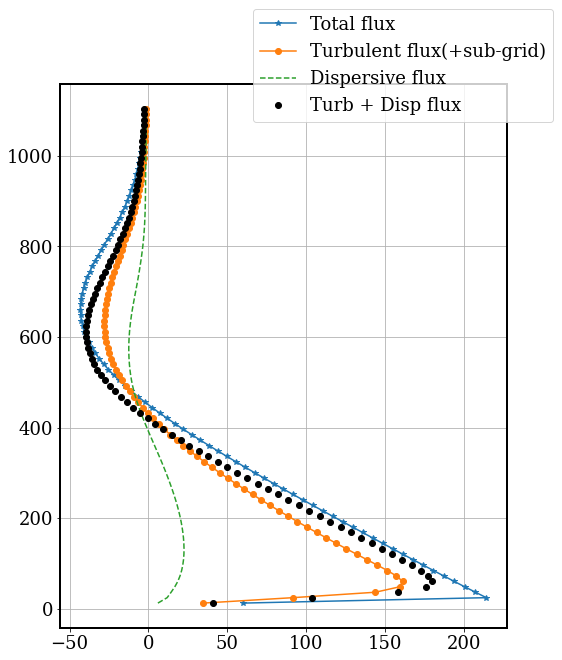

In [144]:
#plot stuff:

fig = plt.figure(figsize=(8,10))
ax = fig.subplots(1,1)

ax.plot(total_H,z_levels,'-*',label='Total flux')
ax.plot(turb_H,z_levels,'-o',label='Turbulent flux(+sub-grid)')
ax.plot(disp_H,z_levels,'--',label='Dispersive flux')
ax.plot(turb_H+disp_H,z_levels,'o',color = 'black', label='Turb + Disp flux')

fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])
plt.grid()


I want to plot the calculated turbulent flux and the calculated resolved scale flux, to check why this difference..

In [145]:
wtheta_turb_profiledata = profile_subset['w*theta*'].rename({'zw*theta*': 'zw_3d'}).sel(zw_3d = slice (10,zi_iop02[4]+200))
wq_turb_profiledata = profile_subset['w*q*'].rename({'zw*q*': 'zw_3d'}).sel(zw_3d = slice (10,zi_iop02[4]+200))


In [166]:
turb_H_profile = np.asarray((wtheta_turb_profiledata))
turb_LE_profile = np.asarray((wq_turb_profiledata))

[########################################] | 100% Completed | 101.43 ms
[########################################] | 100% Completed | 201.42 ms
[########################################] | 100% Completed | 101.35 ms
[########################################] | 100% Completed | 201.28 ms


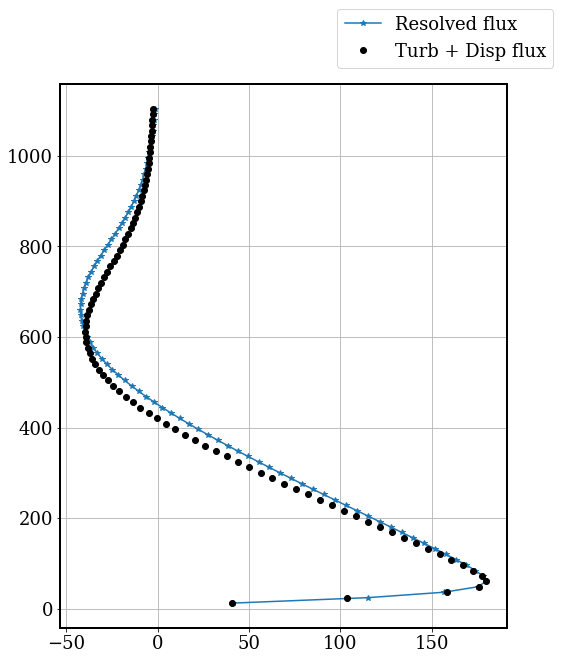

In [148]:
#plot stuff:

fig = plt.figure(figsize=(8,10))
ax = fig.subplots(1,1)

ax.plot(turb_H_profile,z_levels,'-*',label='Resolved flux')
# ax.plot(turb_H,z_levels,'-o',label='Turbulent flux(+sub-grid)')
# ax.plot(disp_H,z_levels,'--',label='Dispersive flux')
ax.plot(turb_H+disp_H,z_levels,'o',color = 'black', label='Turb + Disp flux')

fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])
plt.grid()


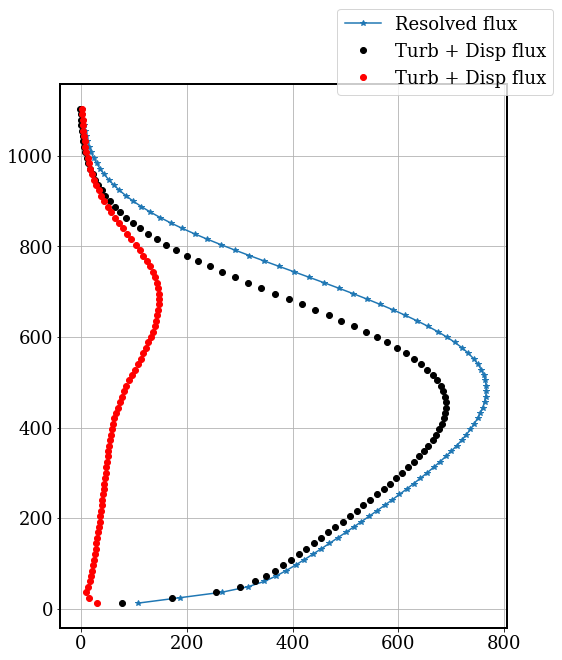

In [154]:
#plot stuff:

fig = plt.figure(figsize=(8,10))
ax = fig.subplots(1,1)

ax.plot(turb_LE_profile,z_levels,'-*',label='Resolved flux')
# ax.plot(turb_H,z_levels,'-o',label='Turbulent flux(+sub-grid)')
# ax.plot(disp_H,z_levels,'--',label='Dispersive flux')
ax.plot(turb_LE+disp_LE,z_levels,'o',color = 'black', label='Turb + Disp flux')
ax.plot(turb_LE_profile-(turb_LE+disp_LE),z_levels,'o',color = 'red', label='Turb + Disp flux')

fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])
plt.grid()


In [155]:
profile_N02_member_2_ds_hom = open_concat_member_files_hom(2,'DATA_1D_PR_NETCDF_N02slice','iop02')
profile_subset_hom = profile_N02_member_2_ds_hom.sel(time=IOP02_time_array).resample(time='30T').mean().sel(time=IOP02_time_array[4])


['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.49538066796958447 seconds


In [170]:
wtheta_turb_profiledata_hom = profile_subset_hom['w*theta*'].rename({'zw*theta*': 'zw_3d'}).sel(zw_3d = slice (10,zi_iop02_hom[4]+200))
wq_turb_profiledata_hom = profile_subset_hom['w*theta*'].rename({'zw*theta*': 'zw_3d'}).sel(zw_3d = slice (10,zi_iop02_hom[4]+200))

turb_H_profile_hom = np.asarray((wtheta_turb_profiledata_hom)*(1.17*1005))
z_levels_hom = np.asarray(profile_subset_hom['zwtheta'].sel(zwtheta = slice (10,zi_iop02_hom[4]+200)))


[########################################] | 100% Completed | 101.93 ms
[########################################] | 100% Completed | 201.65 ms


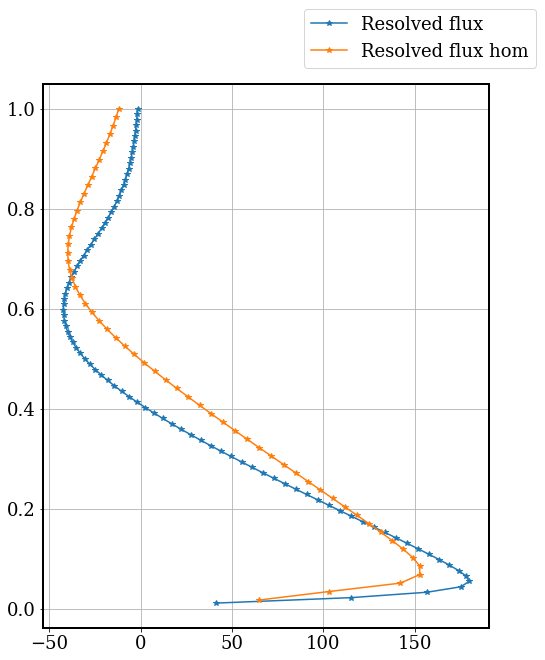

In [169]:
#plot stuff:

fig = plt.figure(figsize=(8,10))
ax = fig.subplots(1,1)

ax.plot(turb_H_profile,z_levels/z_levels[-1],'-*',label='Resolved flux')

ax.plot(turb_H_profile_hom,z_levels_hom/z_levels_hom[-1],'-*',label='Resolved flux hom')

fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])
plt.grid()


#wtheta_turb_profiledata_hom*(1.17*1005)

##### It's okay for now 
##### checkout if there are much differences bw one member and individual members for turb. and disp. fluxes:


In [24]:
IOP02_time_array

['2019-08-23T09:00:00.000000000',
 '2019-08-23T09:30:00.000000000',
 '2019-08-23T10:00:00.000000000',
 '2019-08-23T10:30:00.000000000',
 '2019-08-23T11:00:00.000000000',
 '2019-08-23T11:30:00.000000000',
 '2019-08-23T12:00:00.000000000',
 '2019-08-23T12:30:00.000000000',
 '2019-08-23T13:00:00.000000000',
 '2019-08-23T13:30:00.000000000',
 '2019-08-23T14:00:00.000000000',
 '2019-08-23T14:30:00.000000000',
 '2019-08-23T15:00:00.000000000',
 '2019-08-23T15:30:00.000000000',
 '2019-08-23T16:00:00.000000000']

ABL heights from max. vertical gradient of $\theta$, ensemble mean.

In [245]:
zi_theta_iop02_list = []
for member in np.arange(1,9):
    ds = open_concat_member_files(member,'DATA_3D_AV_NETCDF_N02slice','iop02').sel(time=IOP02_time_array)
    #subset for the sub-domain
    ds1 = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

    zi_theta_av_list = []
    vertical_slice = [600, 600,
                      900, 900, 1100, 1300,
                      1300, 1500, 1700, 1700,
                      1700, 1700, 1700, 1700,
                      1700 ]
    for i, time_step in enumerate(IOP02_time_array):
        theta = ds1.theta.sel(time = time_step)
        zi_xy_av = (theta.sel(zu_3d=slice(0,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
        zi_theta_av_list.append(zi_xy_av)
    zi_theta_iop02 = xr.concat(zi_theta_av_list,'time')
    zi_theta_iop02_list.append(zi_theta_iop02)
zi_theta_iop02_ensemble = xr.concat(zi_theta_iop02_list,'ensemble')


['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.4021391309797764 seconds
[########################################] | 100% Completed | 81.61 s
[########################################] | 100% Completed | 81.71 s
[########################################] | 100% Completed | 26.09 s
[########################################] | 100% Completed | 26.19 s
[########################################] | 100% Completed | 22.21 s
[########################################] | 100% Completed | 22.31 s
[########################################] | 100% Completed | 20.13 s
[########################################] | 100% Completed | 20.23 s
[########################################] | 100% Completed | 13.95 s
[########################################] | 100% Completed | 14.05 s
[###########################

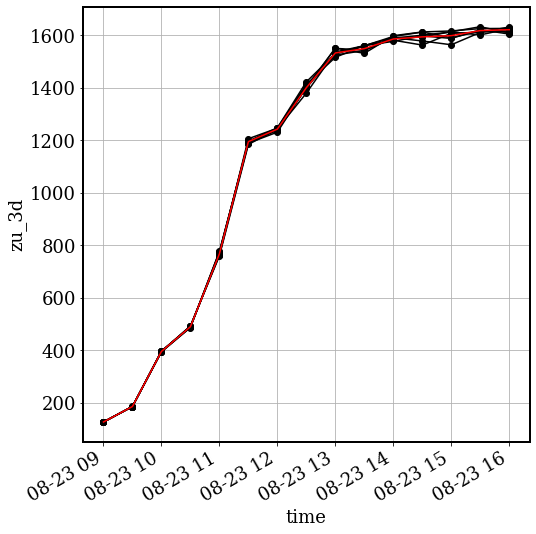

In [254]:
fig, axes = plt.subplots(figsize=(8,8))
for member in np.arange(1,8):
    zi_theta_iop02_ensemble.sel(ensemble=member).plot(marker='o',color='black',ax=axes)
zi_theta_iop02_ensemble.mean('ensemble').plot(color='red',ax=axes)
axes.grid()

In [255]:
zi_theta_iop02_ensemble.mean('ensemble').values

array([ 127.26811317,  186.28140789,  395.95448875,  490.1812074 ,
        767.58835375, 1194.99948318, 1242.73773669, 1400.52554689,
       1532.84613054, 1549.20057474, 1585.96478949, 1593.99945645,
       1598.73579416, 1618.02875473, 1621.44236578])

check for the homogeneous case:

In [38]:
zi_theta_iop02_list = []
for member in np.arange(1,9):
    ds = open_concat_member_files_hom(member,'DATA_3D_AV_NETCDF_N02slice','iop02').sel(time=IOP02_time_array)
    #subset for the sub-domain
    ds1 = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

    zi_theta_av_list = []
    vertical_slice = [600, 600,
                      900, 900, 1100, 1300,
                      1300, 1500, 1700, 1700,
                      1700, 1700, 1700, 1700,
                      1700 ]
    for i, time_step in enumerate(IOP02_time_array):
        theta = ds1.theta.sel(time = time_step)
        zi_xy_av = (theta.sel(zu_3d=slice(10,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean(['x','y']).compute()
        zi_theta_av_list.append(zi_xy_av)
    zi_theta_iop02 = xr.concat(zi_theta_av_list,'time')
    zi_theta_iop02_list.append(zi_theta_iop02)
zi_theta_iop02_ensemble_hom = xr.concat(zi_theta_iop02_list,'ensemble')


['00.ches_IOP2_parent_child1_hom1.9849', '01.ches_IOP2_parent_child1_hom1.29566', '02. ches_IOP2_parent_child1_hom1.9162', '03.ches_IOP2_parent_child1_hom1.7693']
Member 1 finished collecting data
Done with member 1  Time elapsed  1.6228070110082626 seconds
[########################################] | 100% Completed | 18.63 s
[########################################] | 100% Completed | 32.28 s
[########################################] | 100% Completed | 27.32 s
[########################################] | 100% Completed | 12.12 s
[########################################] | 100% Completed | 5.47 ss
[########################################] | 100% Completed | 3.46 ss
[########################################] | 100% Completed | 3.22 ss
[########################################] | 100% Completed | 3.22 ss
[########################################] | 100% Completed | 3.25 ss
[########################################] | 100% Completed | 3.22 ss
[########################################]

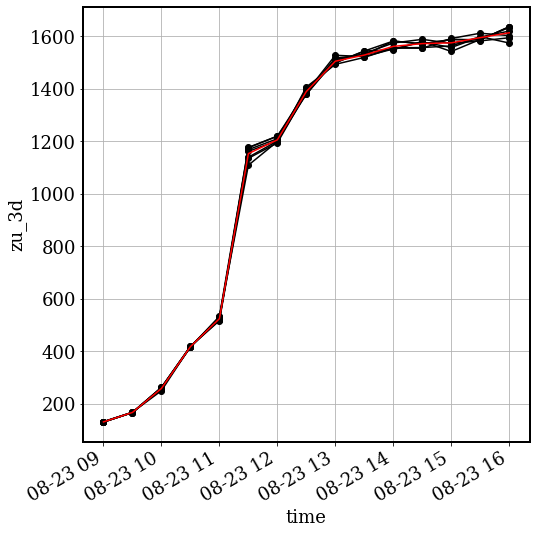

In [39]:
fig, axes = plt.subplots(figsize=(8,8))
for member in np.arange(1,8):
    zi_theta_iop02_ensemble_hom.sel(ensemble=member).plot(marker='o',color='black',ax=axes)
zi_theta_iop02_ensemble_hom.mean('ensemble').plot(color='red',ax=axes)
axes.grid()

In [40]:
zi_theta_iop02_ensemble_hom.mean('ensemble').values

array([ 131.93482736,  167.96090443,  259.27744264,  418.35933616,
        524.81759412, 1153.22989975, 1205.73771887, 1389.72816663,
       1504.96470929, 1528.45960793, 1561.48887948, 1572.03590109,
       1574.96876364, 1594.86374248, 1613.24770773])

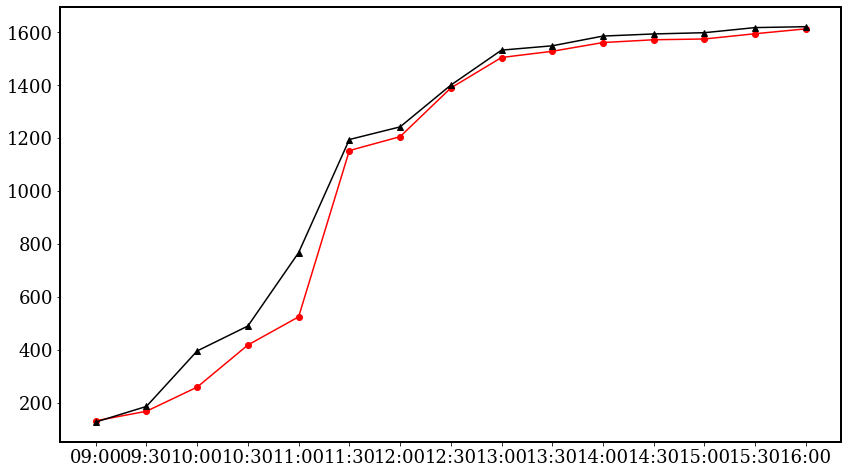

In [47]:
timestamp = zi_theta_iop02_ensemble_hom.mean('ensemble').time.dt.strftime('%H:%M')
plt.figure(figsize=(14,8))
plt.plot(timestamp,[ 131.93482736,  167.96090443,  259.27744264,  418.35933616,
        524.81759412, 1153.22989975, 1205.73771887, 1389.72816663,
       1504.96470929, 1528.45960793, 1561.48887948, 1572.03590109,
       1574.96876364, 1594.86374248, 1613.24770773],'-o',color='red')
plt.plot(timestamp,[ 127.26811317,  186.28140789,  395.95448875,  490.1812074 ,
        767.58835375, 1194.99948318, 1242.73773669, 1400.52554689,
       1532.84613054, 1549.20057474, 1585.96478949, 1593.99945645,
       1598.73579416, 1618.02875473, 1621.44236578] ,'-^',color='black')

In [64]:
zi_theta_iop03_list = []
for member in np.arange(0,8):
    ds = open_concat_member_files(member,'DATA_3D_AV_NETCDF_N02slice','iop03').sel(time=IOP03_time_array)
    #subset for the sub-domain
    ds1 = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

    zi_theta_av_list = []
    vertical_slice =  [200,300,300,400,
                   500,600,800,800,
                   900,1000,1100,1100]    
    for i, time_step in enumerate(IOP03_time_array):
        theta = ds1.theta.sel(time = time_step)
        zi_xy_av = (theta.sel(zu_3d=slice(0,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
        zi_theta_av_list.append(zi_xy_av)
    zi_theta_iop03 = xr.concat(zi_theta_av_list,'time')
    zi_theta_iop03_list.append(zi_theta_iop03)
zi_theta_iop03_ensemble = xr.concat(zi_theta_iop03_list,'ensemble')


['01.ches_IOP3.14592', '02.ches_IOP3.660', '03.ches_IOP3.19260', '04.ches_IOP3.22682', '05.ches_IOP3.31133', '06.ches_IOP3.29659', '07.ches_IOP3.19900', '08.ches_IOP3.24658', '09.ches_IOP3.23660', '10.ches_IOP3.5654', '11.ches_IOP3.1905', '12.ches_IOP3.27019', '13.ches_IOP3.9399', '14.ches_IOP3.5300', '15.ches_IOP3.17284', '16.ches_IOP3.4936', '17.ches_IOP3.29670', '18.ches_IOP3.8982']
Member 0 finished collecting data
Done with member 0  Time elapsed  14.143220614641905 seconds
[########################################] | 100% Completed | 3.27 ss
[########################################] | 100% Completed | 3.75 ss
[########################################] | 100% Completed | 3.83 ss
[########################################] | 100% Completed | 4.67 ss
[########################################] | 100% Completed | 3.53 ss
[########################################] | 100% Completed | 2.93 ss
[########################################] | 100% Completed | 3.33 ss
[#########################

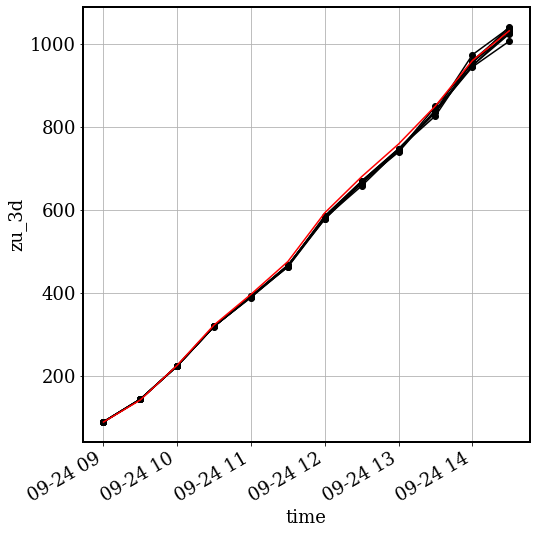

In [65]:
fig, axes = plt.subplots(figsize=(8,8))
for member in np.arange(1,8):
    zi_theta_iop03_ensemble.sel(ensemble=member).plot(marker='o',color='black',ax=axes)
zi_theta_iop03_ensemble.mean('ensemble').plot(color='red',ax=axes)
axes.grid()

In [67]:
zi_theta_iop03_ensemble.mean('ensemble').values

array([  88.62130987,  141.84283359,  225.54037425,  322.57451548,
        396.33941635,  475.2585832 ,  592.48186233,  679.5148229 ,
        758.12848296,  849.92848296,  958.90627311, 1030.6234217 ])

Same for homogeneous runs:

In [31]:
zi_theta_iop02_list_hom = []
for member in np.arange(1,9):
    ds = open_concat_member_files_hom(member,'DATA_3D_AV_NETCDF_N02slice','iop02').sel(time=IOP02_time_array[4:])
    #subset for the sub-domain
    ds1 = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

    zi_theta_av_list = []
    vertical_slice = [900, 1300,
                      1300, 1500, 1700, 1700,
                      1700, 1700, 1700, 1700,
                      1700]
    for i, time_step in enumerate(IOP02_time_array[4:]):
        theta = ds1.theta.sel(time = time_step)
        zi_xy_av = (theta.sel(zu_3d=slice(10,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
        zi_theta_av_list.append(zi_xy_av)
    zi_theta_iop02_hom = xr.concat(zi_theta_av_list,'time')
    zi_theta_iop02_list_hom.append(zi_theta_iop02_hom)
zi_theta_iop02_ensemble_hom = xr.concat(zi_theta_iop02_list_hom,'ensemble')


['00.ches_IOP2_parent_child1_hom1.9849', '01.ches_IOP2_parent_child1_hom1.29566', '02. ches_IOP2_parent_child1_hom1.9162', '03.ches_IOP2_parent_child1_hom1.7693']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.47345516830682755 seconds
[########################################] | 100% Completed | 8.26 ss
[########################################] | 100% Completed | 4.56 ss
[########################################] | 100% Completed | 3.93 ss
[########################################] | 100% Completed | 3.53 ss
[########################################] | 100% Completed | 3.64 ss
[########################################] | 100% Completed | 3.65 ss
[########################################] | 100% Completed | 3.53 ss
[########################################] | 100% Completed | 3.43 ss
[########################################] | 100% Completed | 1.71 ss
[########################################] | 100% Completed | 1.71 ss
[########################################

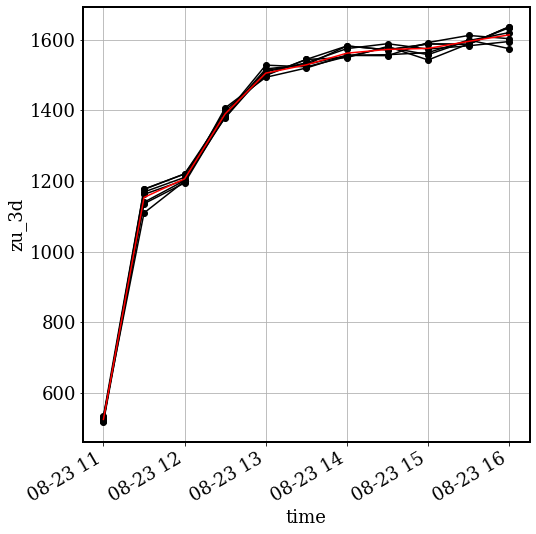

In [32]:
fig, axes = plt.subplots(figsize=(8,8))
for member in np.arange(1,8):
    zi_theta_iop02_ensemble_hom.sel(ensemble=member).plot(marker='o',color='black',ax=axes)
zi_theta_iop02_ensemble_hom.mean('ensemble').plot(color='red',ax=axes)
axes.grid()

In [33]:
zi_theta_iop02_ensemble_hom.mean('ensemble').values

array([ 524.81832925, 1153.22989975, 1205.73771887, 1389.72816663,
       1504.96470929, 1528.45960793, 1561.48887948, 1572.03590109,
       1574.96876364, 1594.86374248, 1613.24770773])

In [78]:
zi_theta_iop03_list_hom = []
for member in np.arange(1,9):
    ds = open_concat_member_files_hom(member,'DATA_3D_AV_NETCDF_N02slice','iop03').sel(time=IOP03_time_array)
    #subset for the sub-domain
    ds1 = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

    zi_theta_av_list_hom = []
    vertical_slice =  [200,300,300,400,
                   500,600,800,800,
                   900,1000,1100,1100]    
    for i, time_step in enumerate(IOP03_time_array):
        theta = ds1.theta.sel(time = time_step)
        zi_xy_av = (theta.sel(zu_3d=slice(10,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
        zi_theta_av_list_hom.append(zi_xy_av)
    zi_theta_iop03_hom = xr.concat(zi_theta_av_list_hom,'time')
    zi_theta_iop03_list_hom.append(zi_theta_iop03_hom)
zi_theta_iop03_ensemble_hom = xr.concat(zi_theta_iop03_list_hom,'ensemble')


['0.ches_IOP3_parent_child1_hom1.12767', '1.ches_IOP3_parent_child1_hom1.14954']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.5908787995576859 seconds
[########################################] | 100% Completed | 34.29 s
[########################################] | 100% Completed | 20.51 s
[########################################] | 100% Completed | 10.94 s
[########################################] | 100% Completed | 7.45 ss
[########################################] | 100% Completed | 6.55 ss
[########################################] | 100% Completed | 5.85 ss
[########################################] | 100% Completed | 5.24 ss
[########################################] | 100% Completed | 5.14 ss
[########################################] | 100% Completed | 5.14 ss
[########################################] | 100% Completed | 6.09 ss
[########################################] | 100% Completed | 2.22 ss
[########################################] | 100% Comp

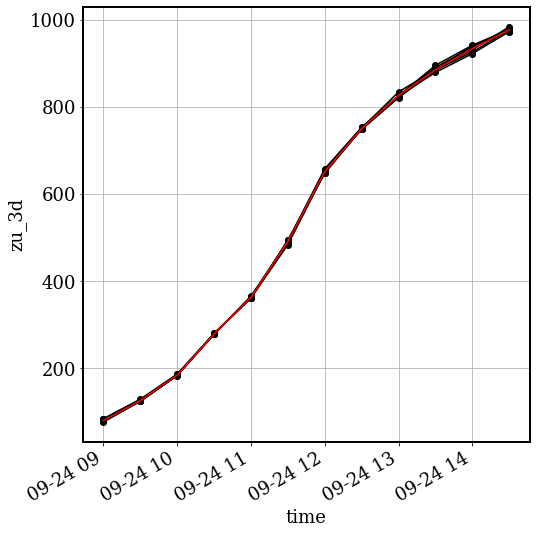

In [79]:
fig, axes = plt.subplots(figsize=(8,8))
for member in np.arange(1,8):
    zi_theta_iop03_ensemble_hom.sel(ensemble=member).plot(marker='o',color='black',ax=axes)
zi_theta_iop03_ensemble_hom.mean('ensemble').plot(color='red',ax=axes)
axes.grid()

In [80]:
zi_theta_iop03_ensemble_hom.mean('ensemble').values

array([ 80.69513477, 126.33890844, 184.98307418, 279.36109601,
       363.49589218, 491.99541546, 652.15589218, 750.80264201,
       826.63606594, 885.59620405, 933.9983738 , 977.12602361])

##### calculate turbulent and dispersive fluxes for all ensemble members for 1100


In [23]:
wtheta_turb_list_iop02 = []
wq_turb_list_iop02 = []

wtheta_disp_list_iop02 = []
wq_disp_list_iop02 = []

time_step = IOP02_time_array[4]
for member in np.arange(1,9):
    ds = open_concat_member_files(member,'DATA_3D_AV_NETCDF_N02slice','iop02').sel(time=time_step)
    #subset for the sub-domain
    ds1 = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02[4]+200),zw_3d=slice(None,zi_iop02[4]+200))      
    wtheta_turb = calculate_turb_flux(ds1)['wtheta_turb_energy'].mean('x').mean('y').compute()
    wq_turb = calculate_turb_flux(ds1)['wq_turb_energy'].mean('x').mean('y').compute()
    wtheta_turb_list_iop02.append(wtheta_turb)
    wq_turb_list_iop02.append(wq_turb)
    
    wtheta_disp, wq_disp = calc_disp_flux(ds1)
    wtheta_disp_list_iop02.append(wtheta_disp)
    wq_disp_list_iop02.append(wq_disp)

wtheta_disp_iop02 = xr.concat(wtheta_disp_list_iop02,dim='ensemble')
wq_disp_iop02 = xr.concat(wq_disp_list_iop02,dim='ensemble')

wtheta_turb_iop02 = xr.concat(wtheta_turb_list_iop02,dim='ensemble')
wq_turb_iop02 = xr.concat(wq_turb_list_iop02,dim='ensemble')

['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.38848506659269333 seconds
[########################################] | 100% Completed | 2.94 sms
[########################################] | 100% Completed | 1.31 sms
[########################################] | 100% Completed | 1.11 sms
[########################################] | 100% Completed | 1.11 sms
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.33653898164629936 seconds
[########################################] | 100% Completed | 1.61 sms
[########################################] | 100% Completed | 1.71 sms
[########################################] | 100% C

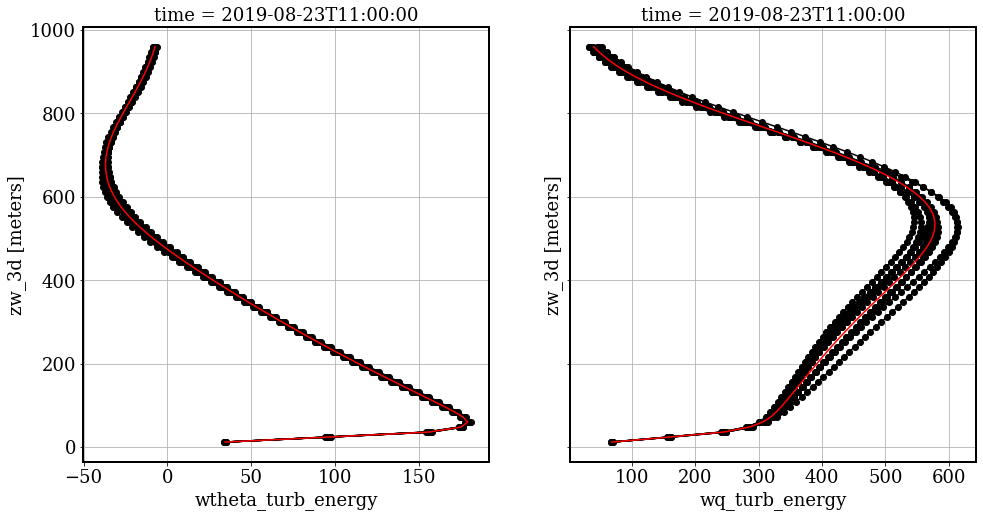

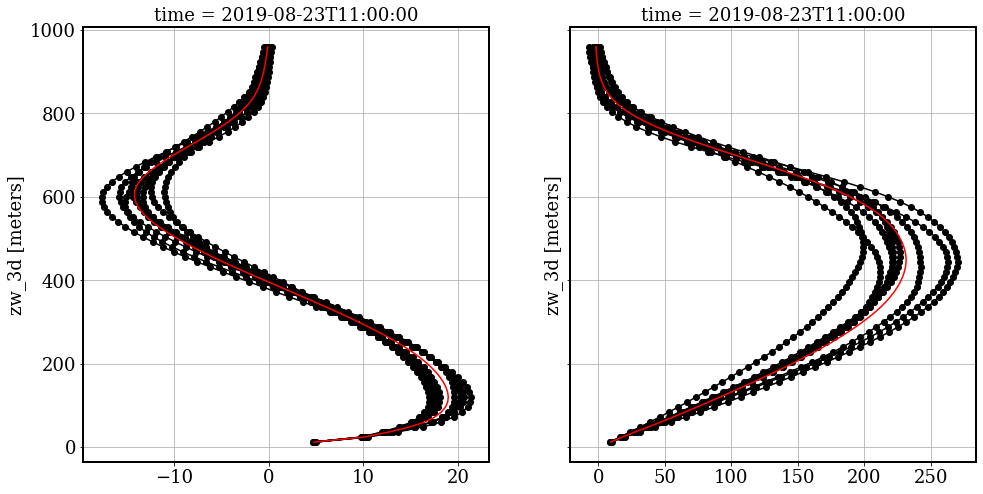

In [39]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)
for member in wtheta_turb_iop02.ensemble:
    wtheta_turb_iop02.sel(ensemble=member).plot(y='zw_3d',marker='o',color='black',ax=axes[0])
    wq_turb_iop02.sel(ensemble=member).plot(y='zw_3d',marker='o',color='black',ax=axes[1])
wtheta_turb_iop02.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[0])
wq_turb_iop02.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[1])
axes[0].grid()
axes[1].grid()

fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)
for member in wtheta_disp_iop02.ensemble:
    wtheta_disp_iop02.sel(ensemble=member).plot(y='zw_3d',marker='o',color='black',ax=axes[0])
    wq_disp_iop02.sel(ensemble=member).plot(y='zw_3d',marker='o',color='black',ax=axes[1])
wtheta_disp_iop02.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[0])
wq_disp_iop02.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[1])
axes[0].grid()
axes[1].grid()

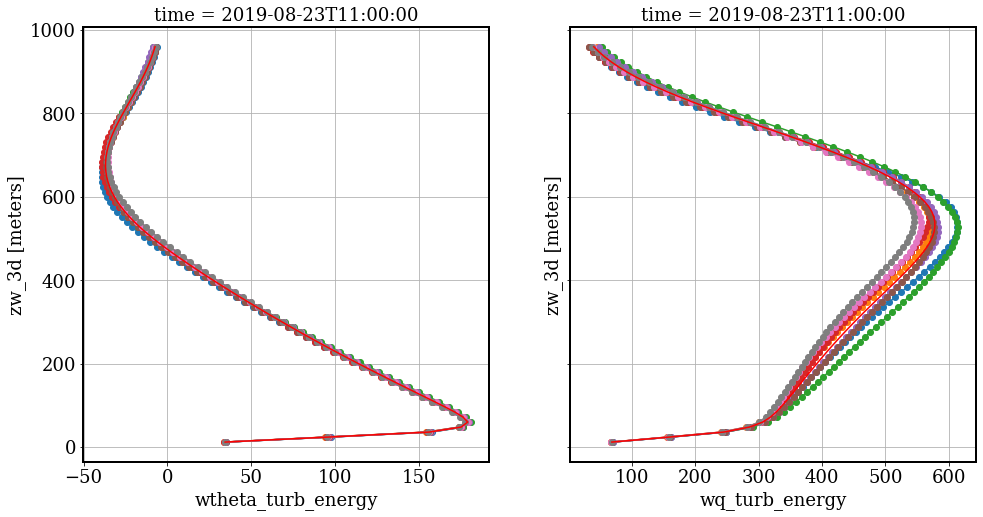

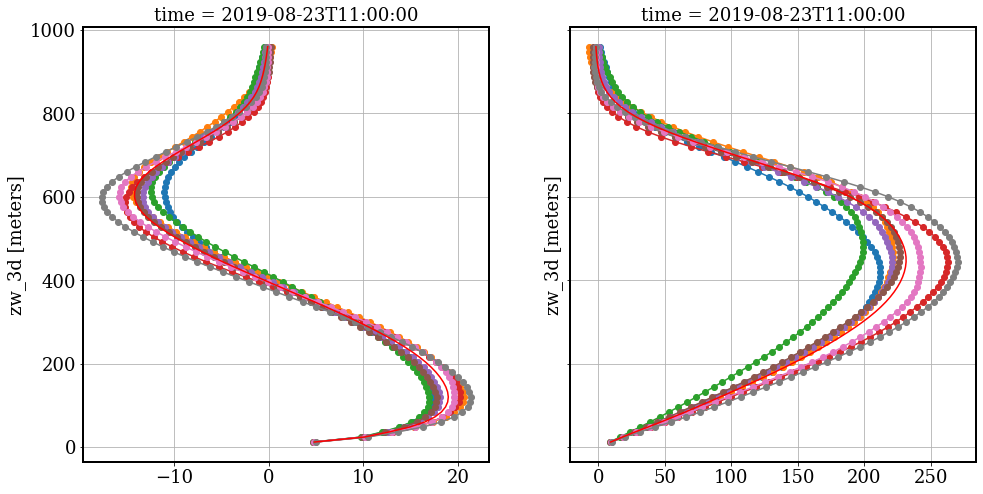

In [37]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)
for member in wtheta_turb_iop02.ensemble:
    wtheta_turb_iop02.sel(ensemble=member).plot(y='zw_3d',marker='o',ax=axes[0])
    wq_turb_iop02.sel(ensemble=member).plot(y='zw_3d',marker='o',ax=axes[1])
wtheta_turb_iop02.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[0])
wq_turb_iop02.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[1])
axes[0].grid()
axes[1].grid()

fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)
for member in wtheta_disp_iop02.ensemble:
    wtheta_disp_iop02.sel(ensemble=member).plot(y='zw_3d',marker='o',ax=axes[0])
    wq_disp_iop02.sel(ensemble=member).plot(y='zw_3d',marker='o',ax=axes[1])
wtheta_disp_iop02.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[0])
wq_disp_iop02.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[1])
axes[0].grid()
axes[1].grid()

There is a partitioning between the turbulent and dispersive fluxes. Higher turbulent, lower dispersive and vice-versa. Checkout how their sum changes with ensemble members:

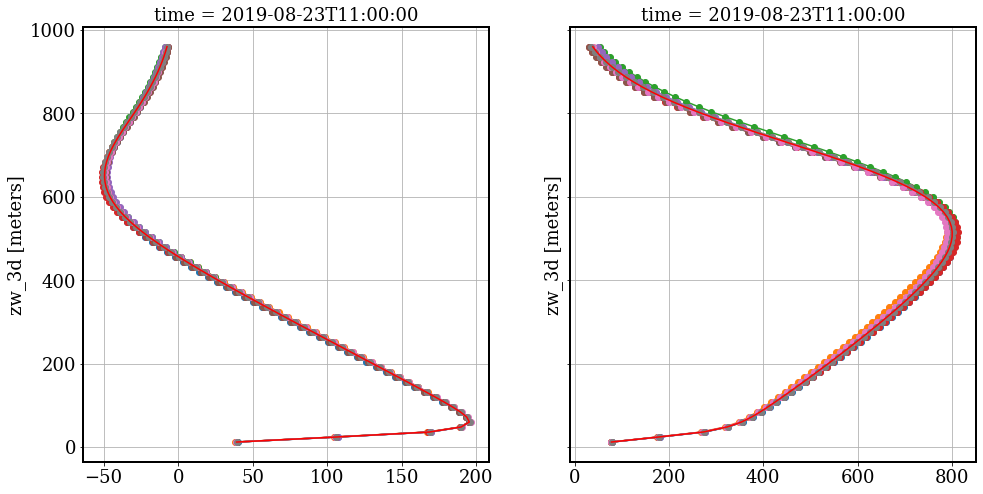

In [38]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)
for member in wtheta_turb_iop02.ensemble:
    (wtheta_turb_iop02.sel(ensemble=member) + wtheta_disp_iop02.sel(ensemble=member)).plot(y='zw_3d',marker='o',ax=axes[0])
    (wq_turb_iop02.sel(ensemble=member) + wq_disp_iop02.sel(ensemble=member)).plot(y='zw_3d',marker='o',ax=axes[1])
(wtheta_turb_iop02.mean('ensemble') + wtheta_disp_iop02.mean('ensemble')).plot(y='zw_3d',color='red',ax=axes[0])
(wq_turb_iop02.mean('ensemble')+wq_disp_iop02.mean('ensemble')).plot(y='zw_3d',color='red',ax=axes[1])
axes[0].grid()
axes[1].grid()

The variation in the total flux between ensemble members is minimal. As one would expect. And it is well represented by the sum of the ensemble means of turbulent and dispersive flux.

redo the same for hom. runs:

In [24]:
#calculate turbulent and dispersive fluxes for all ensemble members for 1100
wtheta_turb_list_iop02_hom = []
wq_turb_list_iop02_hom = []

wtheta_disp_list_iop02_hom = []
wq_disp_list_iop02_hom = []

time_step = IOP02_time_array[4]
for member in np.arange(1,9):
    ds = open_concat_member_files_hom(member,'DATA_3D_AV_NETCDF_N02slice','iop02').sel(time=time_step)
    #subset for the sub-domain
    ds1 = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02_hom[0]+200),zw_3d=slice(None,zi_iop02_hom[0]+200))

    wtheta_turb = calculate_turb_flux(ds1)['wtheta_turb_energy'].mean('x').mean('y').compute()
    wq_turb = calculate_turb_flux(ds1)['wq_turb_energy'].mean('x').mean('y').compute()
    
    wtheta_disp, wq_disp = calc_disp_flux(ds1)

    wtheta_turb_list_iop02_hom.append(wtheta_turb)
    wq_turb_list_iop02_hom.append(wq_turb)
    
    wtheta_disp_list_iop02_hom.append(wtheta_disp)
    wq_disp_list_iop02_hom.append(wq_disp)

wtheta_turb_iop02_hom = xr.concat(wtheta_turb_list_iop02_hom,dim='ensemble')
wq_turb_iop02_hom = xr.concat(wq_turb_list_iop02_hom,dim='ensemble')

wtheta_disp_iop02_hom = xr.concat(wtheta_disp_list_iop02_hom,dim='ensemble')
wq_disp_iop02_hom = xr.concat(wq_disp_list_iop02_hom,dim='ensemble')

['00.ches_IOP2_parent_child1_hom1.9849', '01.ches_IOP2_parent_child1_hom1.29566', '02. ches_IOP2_parent_child1_hom1.9162', '03.ches_IOP2_parent_child1_hom1.7693']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.2638532370328903 seconds
[########################################] | 100% Completed | 1.01 sms
[########################################] | 100% Completed | 1.01 sms
[########################################] | 100% Completed | 907.31 ms
[########################################] | 100% Completed | 907.34 ms
['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.22963204607367516 seconds
[########################################] | 100% Completed | 1.01 sms
[########################################] | 100% Completed | 1.01 sms
[########################################] | 100% Completed | 806.80 ms
[########################################] | 100% Completed | 806.

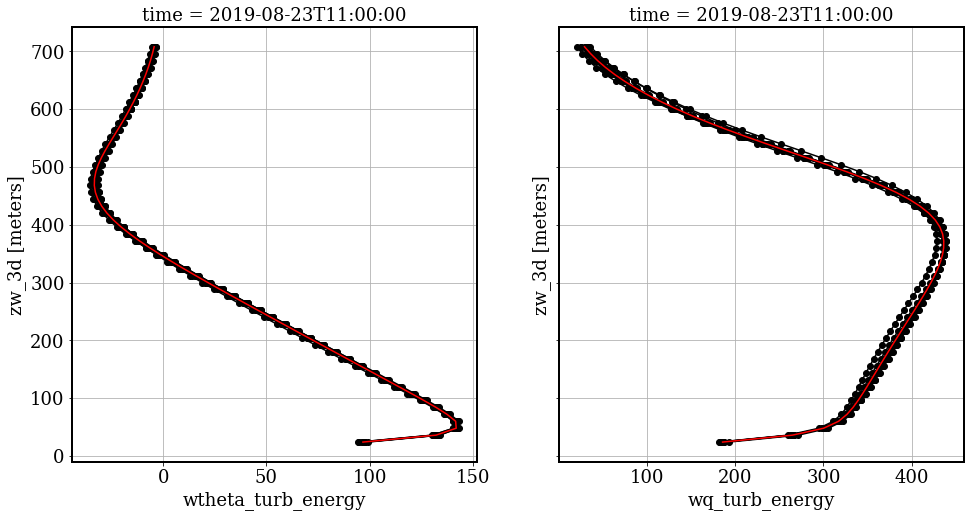

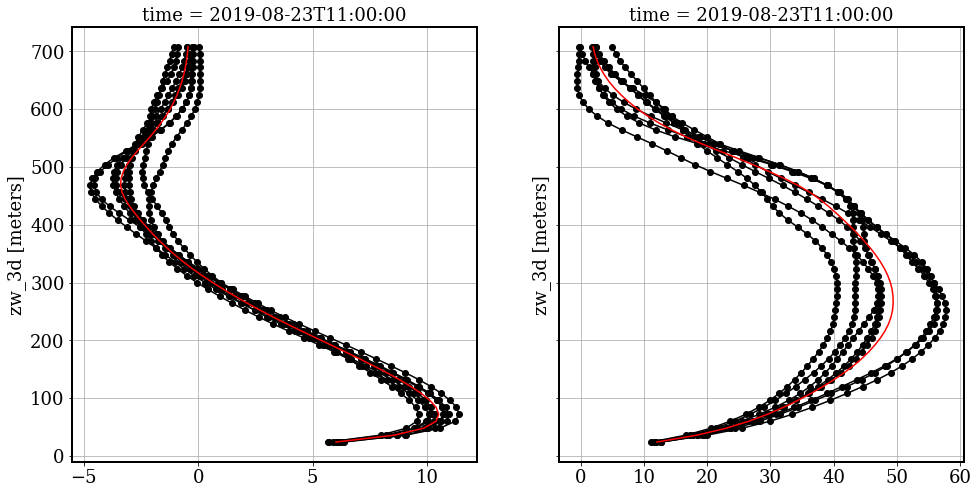

In [43]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)
for member in wtheta_turb_iop02_hom.ensemble:
    wtheta_turb_iop02_hom.sel(ensemble=member).plot(y='zw_3d',marker='o',color='black',ax=axes[0])
    wq_turb_iop02_hom.sel(ensemble=member).plot(y='zw_3d',marker='o',color='black',ax=axes[1])
wtheta_turb_iop02_hom.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[0])
wq_turb_iop02_hom.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[1])
axes[0].grid()
axes[1].grid()

fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)
for member in wtheta_disp_iop02_hom.ensemble:
    wtheta_disp_iop02_hom.sel(ensemble=member).plot(y='zw_3d',marker='o',color='black',ax=axes[0])
    wq_disp_iop02_hom.sel(ensemble=member).plot(y='zw_3d',marker='o',color='black',ax=axes[1])
wtheta_disp_iop02_hom.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[0])
wq_disp_iop02_hom.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[1])
axes[0].grid()
axes[1].grid()

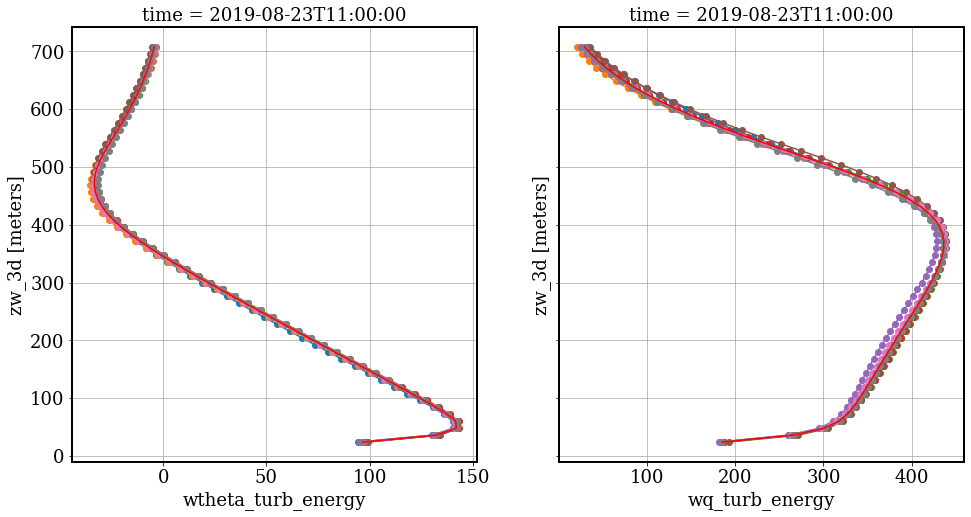

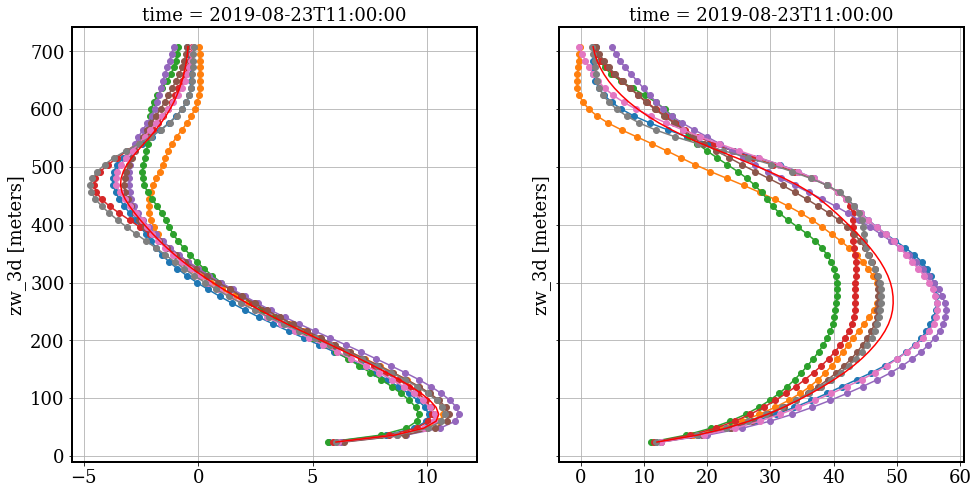

In [44]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)
for member in wtheta_turb_iop02_hom.ensemble:
    wtheta_turb_iop02_hom.sel(ensemble=member).plot(y='zw_3d',marker='o',ax=axes[0])
    wq_turb_iop02_hom.sel(ensemble=member).plot(y='zw_3d',marker='o',ax=axes[1])
wtheta_turb_iop02_hom.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[0])
wq_turb_iop02_hom.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[1])
axes[0].grid()
axes[1].grid()

fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)
for member in wtheta_disp_iop02_hom.ensemble:
    wtheta_disp_iop02_hom.sel(ensemble=member).plot(y='zw_3d',marker='o',ax=axes[0])
    wq_disp_iop02_hom.sel(ensemble=member).plot(y='zw_3d',marker='o',ax=axes[1])
wtheta_disp_iop02_hom.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[0])
wq_disp_iop02_hom.mean('ensemble').plot(y='zw_3d',color='red',ax=axes[1])
axes[0].grid()
axes[1].grid()

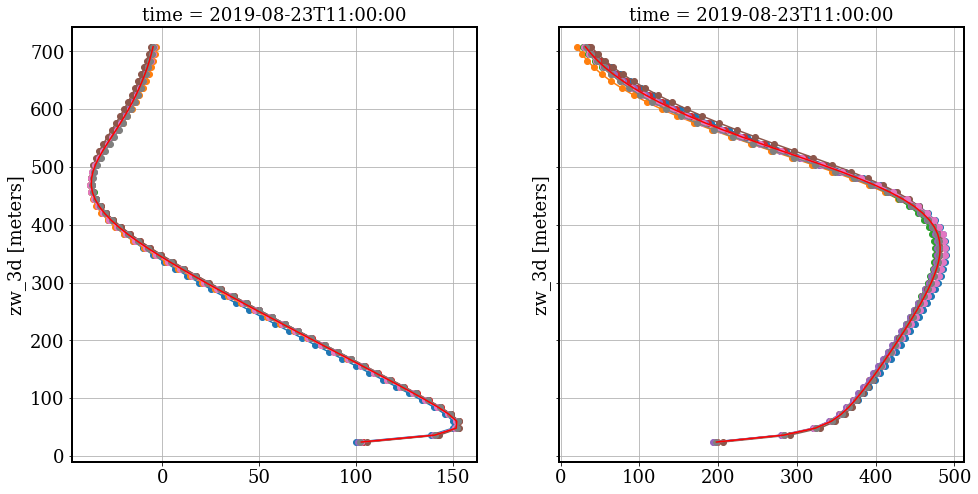

In [45]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)
for member in wtheta_turb_iop02_hom.ensemble:
    (wtheta_turb_iop02_hom.sel(ensemble=member) + wtheta_disp_iop02_hom.sel(ensemble=member)).plot(y='zw_3d',marker='o',ax=axes[0])
    (wq_turb_iop02_hom.sel(ensemble=member) + wq_disp_iop02_hom.sel(ensemble=member)).plot(y='zw_3d',marker='o',ax=axes[1])
(wtheta_turb_iop02_hom.mean('ensemble') + wtheta_disp_iop02_hom.mean('ensemble')).plot(y='zw_3d',color='red',ax=axes[0])
(wq_turb_iop02_hom.mean('ensemble')+wq_disp_iop02_hom.mean('ensemble')).plot(y='zw_3d',color='red',ax=axes[1])
axes[0].grid()
axes[1].grid()

compare the hom. vs het. runs:

In [25]:
wtheta_hom = profile_N02_member_2_ds_hom.resample(time='30T').mean()['wtheta']
wtheta = profile_N02_member_2_ds.resample(time='30T').mean()['wtheta']

wq_hom = profile_N02_member_2_ds_hom.resample(time='30T').mean()['wq']
wq = profile_N02_member_2_ds.resample(time='30T').mean()['wq']


In [26]:
#print((wtheta_hom.sel(time=IOP02_time_array[4])[0]*(1.17*1005)).compute().values)
time_index = 4
print(IOP02_time_array[time_index])
wtheta_surf_hom = (wtheta_hom.sel(time=IOP02_time_array[time_index])[0]*(1.17*1005)).compute().values

#print(wtheta.sel(time=IOP02_time_array[4])[3].compute().values)
wtheta_surf = wtheta.sel(time=IOP02_time_array[time_index])[3].compute().values

wq_surf_hom = (wq_hom.sel(time=IOP02_time_array[time_index])[0]*(1.17*1000*2500)).compute().values
wq_surf = wq.sel(time=IOP02_time_array[time_index])[3].compute().values


2019-08-23T11:00:00.000000000
[########################################] | 100% Completed | 231.69 ms
[########################################] | 100% Completed | 101.28 ms
[########################################] | 100% Completed | 101.14 ms
[########################################] | 100% Completed | 101.29 ms


the near surface totals for the whole domain are same/close by

In [110]:
#near surface values:
print((wtheta_turb_iop02.mean('ensemble')+wtheta_disp_iop02.mean('ensemble')).sel(zw_3d=36).values)
print((wtheta_turb_iop02_hom.mean('ensemble')+wtheta_disp_iop02_hom.mean('ensemble')).sel(zw_3d=36).values)

168.52602
140.7923


In [109]:
print((wq_turb_iop02.mean('ensemble')+wq_disp_iop02.mean('ensemble')).sel(zw_3d=36).values)
print((wq_turb_iop02_hom.mean('ensemble')+wq_disp_iop02_hom.mean('ensemble')).sel(zw_3d=36).values)

272.74594
283.35233


I will normalize both by the domain mean total fluxes from the full domain. Why? That was the imposed surface flux for hom. cases and since they are homogeneous runs, their domain mean surface flux should not change by domain size. I will go ahead with that idea.

In [27]:
H_turb = wtheta_turb_iop02.mean('ensemble').values
LE_turb = wq_turb_iop02.mean('ensemble').values

H_disp = wtheta_disp_iop02.mean('ensemble').values
LE_disp = wq_disp_iop02.mean('ensemble').values

H_turb_hom = wtheta_turb_iop02_hom.mean('ensemble').values[1:]
LE_turb_hom = wq_turb_iop02_hom.mean('ensemble').values[1:]

H_disp_hom = wtheta_disp_iop02_hom.mean('ensemble').values[1:]
LE_disp_hom = wq_disp_iop02_hom.mean('ensemble').values[1:]

H_tot = H_turb+H_disp
H_tot_hom = H_turb_hom+H_disp_hom

LE_tot = LE_turb+LE_disp
LE_tot_hom = LE_turb_hom+LE_disp_hom



In [28]:
z_plot = wtheta_turb_iop02.zw_3d/zi_iop02[4]
z_plot_hom = wtheta_turb_iop02_hom.zw_3d[1:]/zi_iop02_hom[0]

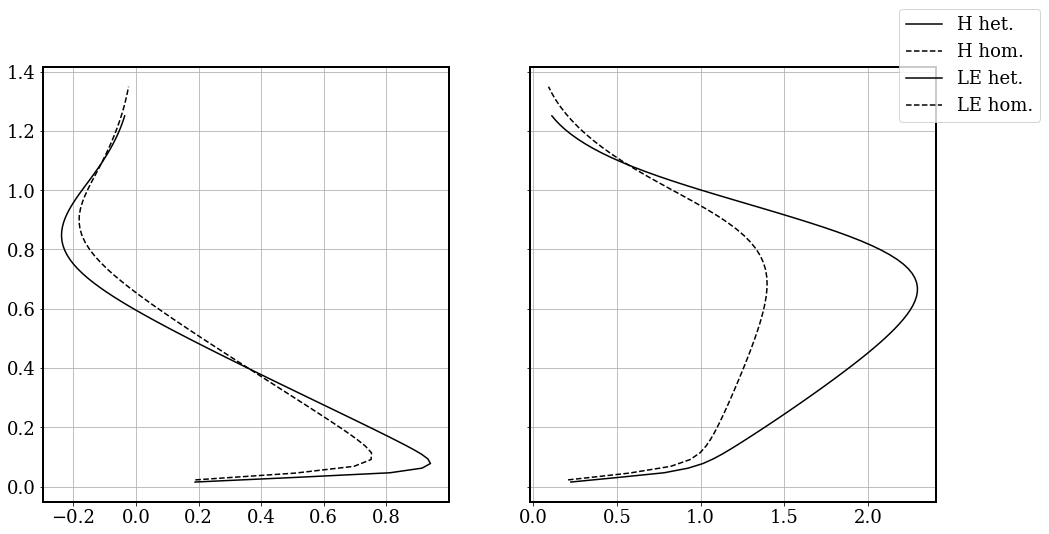

In [131]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)

axes[0].plot(H_tot/wtheta_surf,z_plot,'-',color='black',label='H het.')
axes[0].plot(H_tot_hom/wtheta_surf_hom,z_plot_hom,'--',color='black',label='H hom.')

axes[1].plot(LE_tot/wq_surf,z_plot,'-',color='black',label='LE het.')
axes[1].plot(LE_tot_hom/wq_surf_hom,z_plot_hom,'--',color='black',label='LE hom.')

fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()

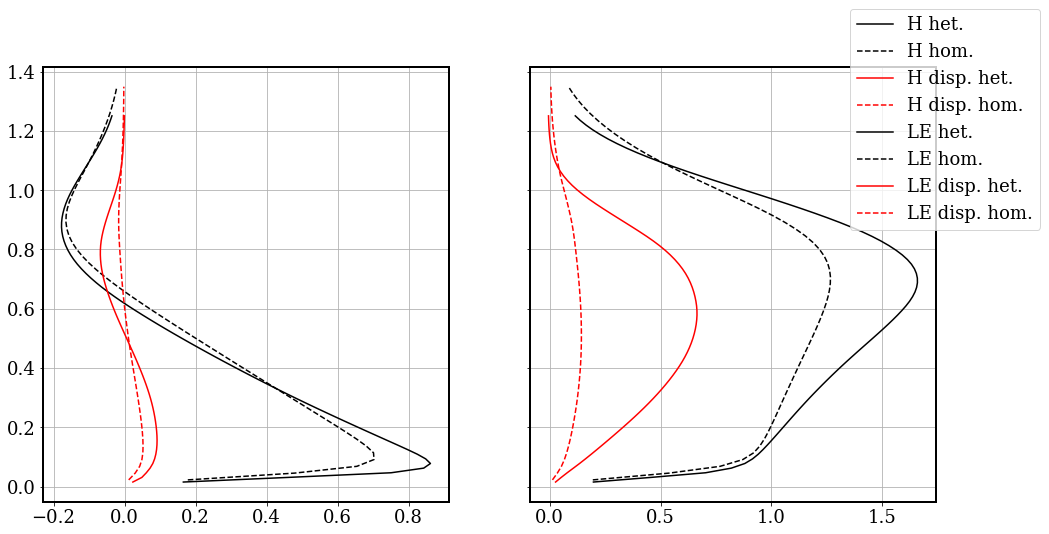

In [28]:


fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)

axes[0].plot(H_turb/wtheta_surf,z_plot,'-',color='black',label='H het.')
axes[0].plot(H_turb_hom/wtheta_surf_hom,z_plot_hom,'--',color='black',label='H hom.')
axes[0].plot(H_disp/wtheta_surf,z_plot,'-',color='red',label='H disp. het.')
axes[0].plot(H_disp_hom/wtheta_surf_hom,z_plot_hom,'--',color='red',label='H disp. hom.')

axes[1].plot(LE_turb/wq_surf,z_plot,'-',color='black',label='LE het.')
axes[1].plot(LE_turb_hom/wq_surf_hom,z_plot_hom,'--',color='black',label='LE hom.')
axes[1].plot(LE_disp/wq_surf,z_plot,'-',color='red',label='LE disp. het.')
axes[1].plot(LE_disp_hom/wq_surf_hom,z_plot_hom,'--',color='red',label='LE disp. hom.')

fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()

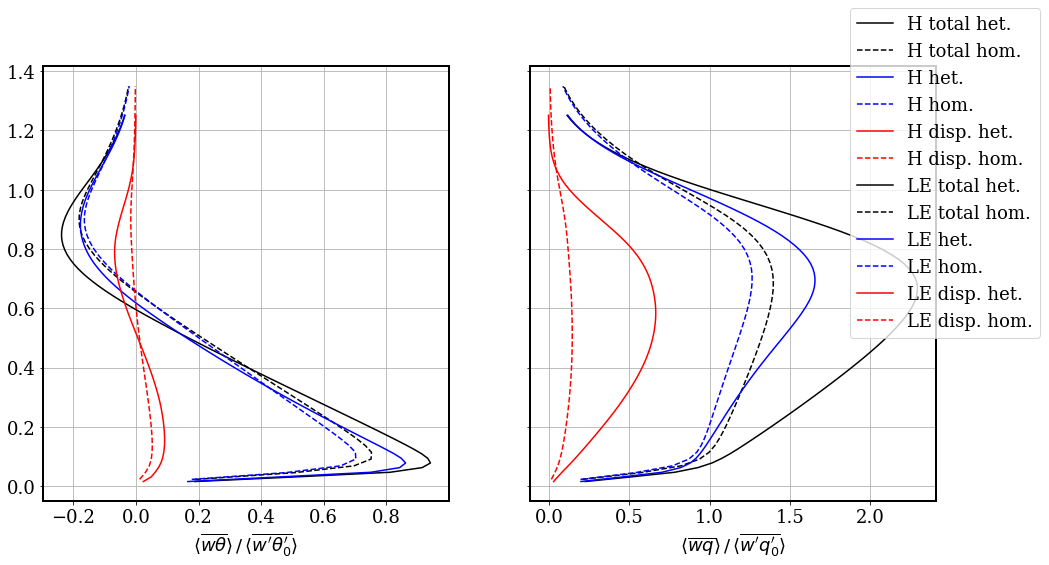

In [29]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)

#total fluxes
axes[0].plot(H_tot/wtheta_surf,z_plot,'-',color='black',label='H total het.')
axes[0].plot(H_tot_hom/wtheta_surf_hom,z_plot_hom,'--',color='black',label='H total hom.')

axes[1].plot(LE_tot/wq_surf,z_plot,'-',color='black',label='LE total het.')
axes[1].plot(LE_tot_hom/wq_surf_hom,z_plot_hom,'--',color='black',label='LE total hom.')

axes[0].plot(H_turb/wtheta_surf,z_plot,'-',color='blue',label='H het.')
axes[0].plot(H_turb_hom/wtheta_surf_hom,z_plot_hom,'--',color='blue',label='H hom.')
axes[0].plot(H_disp/wtheta_surf,z_plot,'-',color='red',label='H disp. het.')
axes[0].plot(H_disp_hom/wtheta_surf_hom,z_plot_hom,'--',color='red',label='H disp. hom.')
axes[0].set_xlabel(r"$ \langle \overline{w\theta} \rangle \, / \, \langle \overline{w'\theta_{0}'} \rangle$")

axes[1].plot(LE_turb/wq_surf,z_plot,'-',color='blue',label='LE het.')
axes[1].plot(LE_turb_hom/wq_surf_hom,z_plot_hom,'--',color='blue',label='LE hom.')
axes[1].plot(LE_disp/wq_surf,z_plot,'-',color='red',label='LE disp. het.')
axes[1].plot(LE_disp_hom/wq_surf_hom,z_plot_hom,'--',color='red',label='LE disp. hom.')
axes[1].set_xlabel(r"$ \langle \overline{wq} \rangle \, / \, \langle \overline{w'q_{0}'} \rangle$")


fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()

##### I'm wondering how does this look for the whole domain between the two?

In [142]:
wtheta_11 = wtheta.sel(time=IOP02_time_array[time_index],zwtheta=wtheta_turb_iop02.zw_3d.values).compute().values
wtheta_11_hom = (wtheta_hom.sel(time=IOP02_time_array[time_index],zwtheta=wtheta_turb_iop02_hom.zw_3d.values)*(1.17*1005)).compute().values[1:]

wq_11 = wq.sel(time=IOP02_time_array[time_index],zwq=wq_turb_iop02.zw_3d.values).compute().values
wq_11_hom = (wq_hom.sel(time=IOP02_time_array[time_index],zwq=wq_turb_iop02_hom.zw_3d.values)*(1.17*1000*2500)).compute().values[1:]


[########################################] | 100% Completed | 101.70 ms
[########################################] | 100% Completed | 101.31 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 101.18 ms


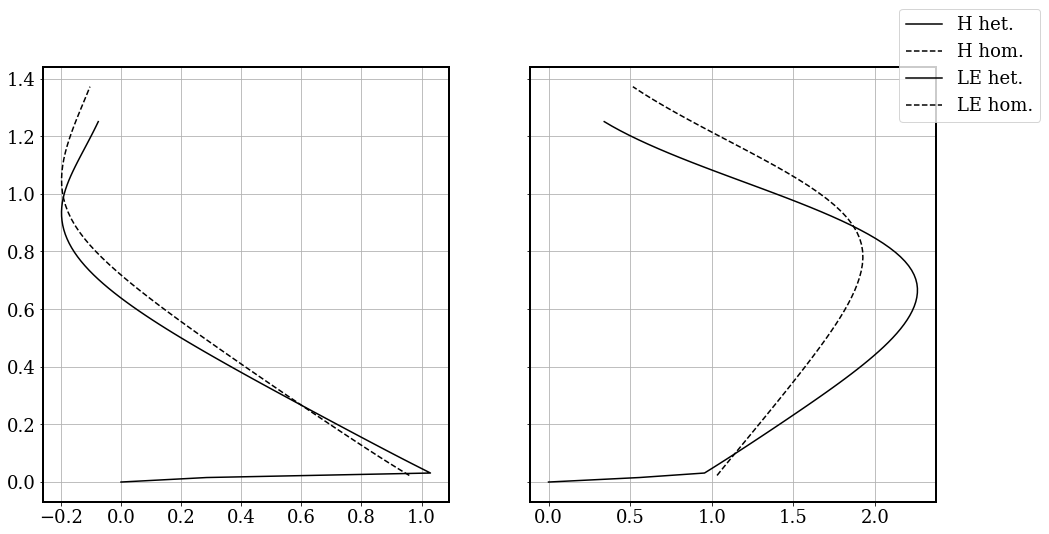

In [143]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)

axes[0].plot(wtheta_11/wtheta_surf,z_plot,'-',color='black',label='H het.')
axes[0].plot(wtheta_11_hom/wtheta_surf_hom,z_plot_hom,'--',color='black',label='H hom.')

axes[1].plot(wq_11/wq_surf,z_plot,'-',color='black',label='LE het.')
axes[1].plot(wq_11_hom/wq_surf_hom,z_plot_hom,'--',color='black',label='LE hom.')

fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()

##### continue..

##### repeat, but plot turbulent,heterogeneity induced, from ensemble means:

In [30]:
wtheta_ensemble_disp_list_iop02 = []
wq_ensemble_disp_list_iop02 = []

time_step = IOP02_time_array[4]

ds1 = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02[4]+200),zw_3d=slice(None,zi_iop02[4]+200),time=time_step).mean('ensemble')

#subset for the sub-domain
wtheta_ensemble_disp, wq_ensemble_disp = calc_disp_flux(ds1)


[########################################] | 100% Completed | 312.46 s
[########################################] | 100% Completed | 274.33 s


In [31]:
time_step = IOP02_time_array[4]

ds1 = ensemble_ds_iop02_N02_hom.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02_hom[0]+200),zw_3d=slice(None,zi_iop02_hom[0]+200),time=time_step).mean('ensemble')

#subset for the sub-domain
wtheta_ensemble_disp_hom, wq_ensemble_disp_hom = calc_disp_flux(ds1)


[########################################] | 100% Completed | 141.40 s
[########################################] | 100% Completed | 145.15 s


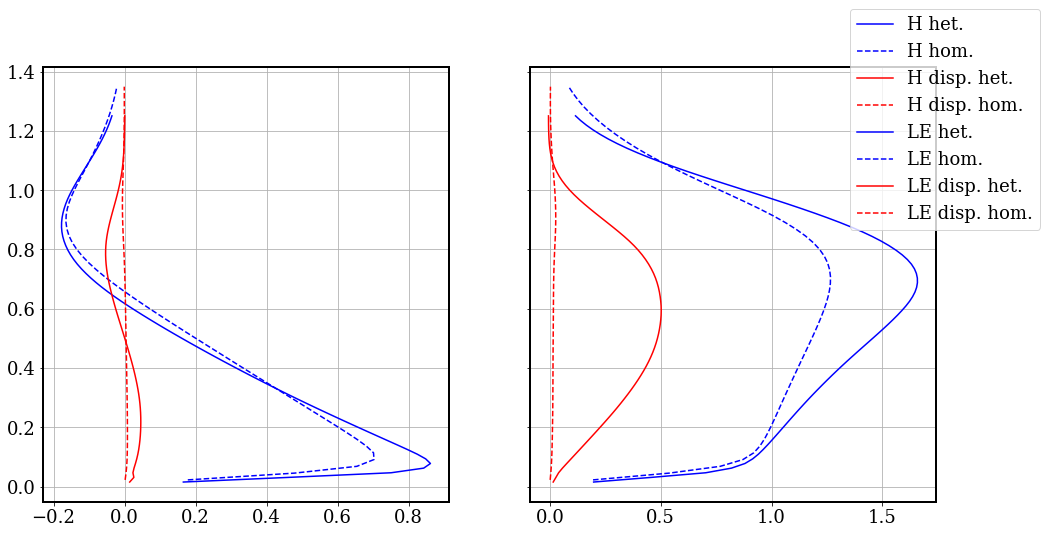

In [32]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)

#total fluxes
# axes[0].plot(H_tot/wtheta_surf,z_plot,'-',color='black',label='H total het.')
# axes[0].plot(H_tot_hom/wtheta_surf_hom,z_plot_hom,'--',color='black',label='H total hom.')

# axes[1].plot(LE_tot/wq_surf,z_plot,'-',color='black',label='LE total het.')
# axes[1].plot(LE_tot_hom/wq_surf_hom,z_plot_hom,'--',color='black',label='LE total hom.')

axes[0].plot(H_turb/wtheta_surf,z_plot,'-',color='blue',label='H het.')
axes[0].plot(H_turb_hom/wtheta_surf_hom,z_plot_hom,'--',color='blue',label='H hom.')
axes[0].plot(wtheta_ensemble_disp/wtheta_surf,z_plot,'-',color='red',label='H disp. het.')
axes[0].plot(wtheta_ensemble_disp_hom[1:]/wtheta_surf_hom,z_plot_hom,'--',color='red',label='H disp. hom.')

axes[1].plot(LE_turb/wq_surf,z_plot,'-',color='blue',label='LE het.')
axes[1].plot(LE_turb_hom/wq_surf_hom,z_plot_hom,'--',color='blue',label='LE hom.')
axes[1].plot(wq_ensemble_disp/wq_surf,z_plot,'-',color='red',label='LE disp. het.')
axes[1].plot(wq_ensemble_disp_hom[1:]/wq_surf_hom,z_plot_hom,'--',color='red',label='LE disp. hom.')


fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()

Why is there a variation for dispersive fluxes between members? \
The spatial organisation is different between members\
There is a persistent contribution from surface- as evident in the covariance of the ensemble mean fields, or dispersive fluxes caused by the ensemble mean fields. \
Check if there is a partitioning between turbulent and dispersive fluxes for each member run. Higher disp. -> lower turb. 
I'd imagine so.
Also, the surface total fluxes (36m for het. and 0m for hom.) should be the same. ie domain mean turb and disp. fluxes should be the same between the heterogeneous and homgeneous runs..

plot four plots, with tot, turb, disp, in one and tot, turb, hi in the other

In [49]:
pwd()

'/bog/incoming/CHEESEHEAD/palm/realistic_runs/python_scripts/spaleri'

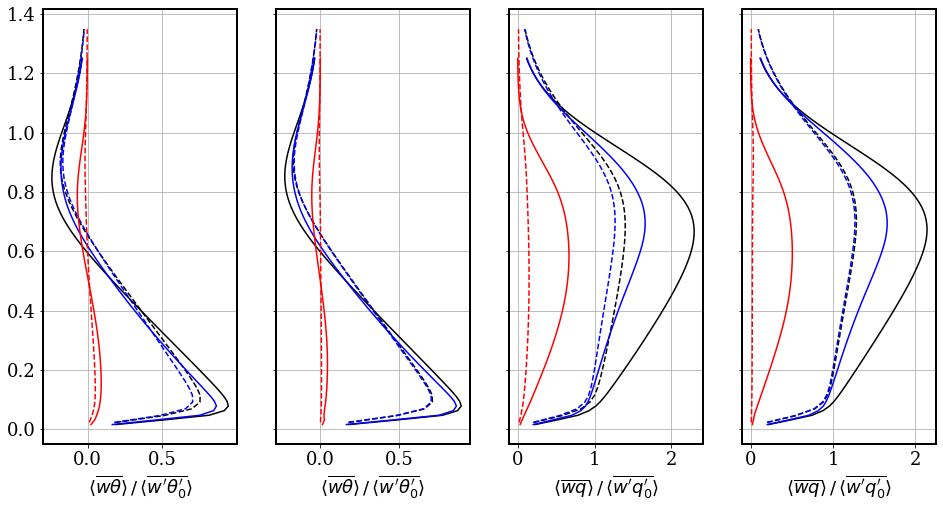

In [50]:
fig, (axes) = plt.subplots(1,4, figsize=(16,8), sharey=True)

axes[0].plot(H_tot/wtheta_surf,z_plot,'-',color='black',label='H total het.')
axes[0].plot(H_tot_hom/wtheta_surf_hom,z_plot_hom,'--',color='black',label='H total hom.')
axes[0].plot(H_turb/wtheta_surf,z_plot,'-',color='blue',label='H het.')
axes[0].plot(H_turb_hom/wtheta_surf_hom,z_plot_hom,'--',color='blue',label='H hom.')
axes[0].plot(H_disp/wtheta_surf,z_plot,'-',color='red',label='H disp. het.')
axes[0].plot(H_disp_hom/wtheta_surf_hom,z_plot_hom,'--',color='red',label='H disp. hom.')


#total fluxes (turb+het.)
axes[1].plot((H_turb+wtheta_ensemble_disp)/wtheta_surf,z_plot,'-',color='black',label='H total het.')
axes[1].plot((H_turb_hom+wtheta_ensemble_disp_hom[1:])/wtheta_surf_hom,z_plot_hom,'--',color='black',label='H total hom.')
#turbulent fluxes
axes[1].plot(H_turb/wtheta_surf,z_plot,'-',color='blue',label='H het.')
axes[1].plot(H_turb_hom/wtheta_surf_hom,z_plot_hom,'--',color='blue',label='H hom.')
#disp. fluxes
axes[1].plot(wtheta_ensemble_disp/wtheta_surf,z_plot,'-',color='red',label='H disp. het.')
axes[1].plot(wtheta_ensemble_disp_hom[1:]/wtheta_surf_hom,z_plot_hom,'--',color='red',label='H disp. hom.')


axes[2].plot(LE_tot/wq_surf,z_plot,'-',color='black',label='LE total het.')
axes[2].plot(LE_tot_hom/wq_surf_hom,z_plot_hom,'--',color='black',label='LE total hom.')
axes[2].plot(LE_turb/wq_surf,z_plot,'-',color='blue',label='LE het.')
axes[2].plot(LE_turb_hom/wq_surf_hom,z_plot_hom,'--',color='blue',label='LE hom.')
axes[2].plot(LE_disp/wq_surf,z_plot,'-',color='red',label='LE disp. het.')
axes[2].plot(LE_disp_hom/wq_surf_hom,z_plot_hom,'--',color='red',label='LE disp. hom.')

axes[3].plot((LE_turb+wq_ensemble_disp)/wq_surf,z_plot,'-',color='black',label='LE total het.')
axes[3].plot((LE_turb_hom+wq_ensemble_disp_hom[1:])/wq_surf_hom,z_plot_hom,'--',color='black',label='LE total hom.')
axes[3].plot(LE_turb/wq_surf,z_plot,'-',color='blue',label='LE het.')
axes[3].plot(LE_turb_hom/wq_surf_hom,z_plot_hom,'--',color='blue',label='LE hom.')
axes[3].plot(wq_ensemble_disp/wq_surf,z_plot,'-',color='red',label='H disp. het.')
axes[3].plot(wq_ensemble_disp_hom[1:]/wq_surf_hom,z_plot_hom,'--',color='red',label='H disp. hom.')

axes[0].set_xlabel(r"$ \langle \overline{w\theta} \rangle \, / \, \langle \overline{w'\theta_{0}'} \rangle$")
axes[1].set_xlabel(r"$ \langle \overline{w\theta} \rangle \, / \, \langle \overline{w'\theta_{0}'} \rangle$")
axes[2].set_xlabel(r"$ \langle \overline{wq} \rangle \, / \, \langle \overline{w'q_{0}'} \rangle$")
axes[3].set_xlabel(r"$ \langle \overline{wq} \rangle \, / \, \langle \overline{w'q_{0}'} \rangle$")

#fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()
axes[2].grid()
axes[3].grid()
plt.savefig('plots/domain_mean_flux_profiles/hom_vs_het_profiles_iop02_1100.png',dpi=300)

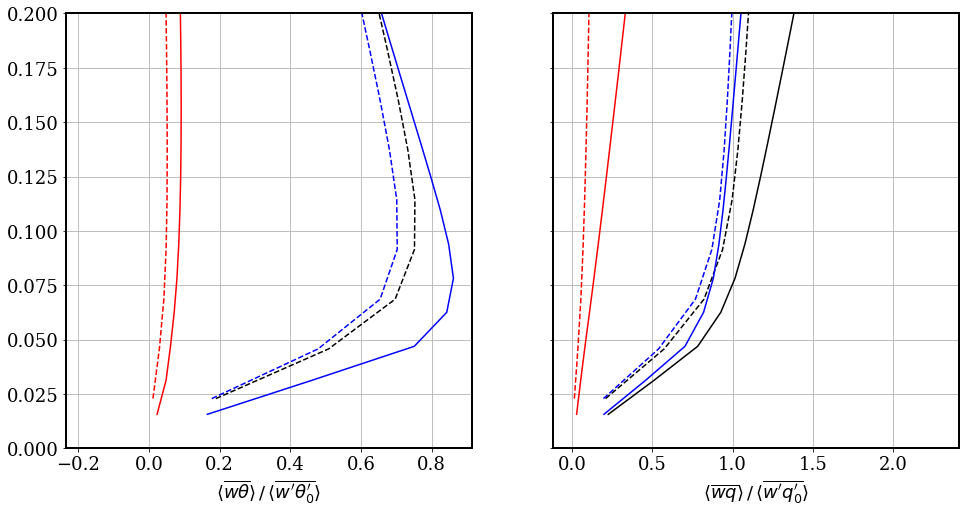

In [44]:
fig, (axes) = plt.subplots(1,2, figsize=(16,8), sharey=True)

axes[0].plot(H_tot_hom/wtheta_surf_hom,z_plot_hom,'--',color='black',label='H total hom.')
axes[0].plot(H_turb/wtheta_surf,z_plot,'-',color='blue',label='H het.')
axes[0].plot(H_turb_hom/wtheta_surf_hom,z_plot_hom,'--',color='blue',label='H hom.')
axes[0].plot(H_disp/wtheta_surf,z_plot,'-',color='red',label='H disp. het.')
axes[0].plot(H_disp_hom/wtheta_surf_hom,z_plot_hom,'--',color='red',label='H disp. hom.')


axes[1].plot(LE_tot/wq_surf,z_plot,'-',color='black',label='LE total het.')
axes[1].plot(LE_tot_hom/wq_surf_hom,z_plot_hom,'--',color='black',label='LE total hom.')
axes[1].plot(LE_turb/wq_surf,z_plot,'-',color='blue',label='LE het.')
axes[1].plot(LE_turb_hom/wq_surf_hom,z_plot_hom,'--',color='blue',label='LE hom.')
axes[1].plot(LE_disp/wq_surf,z_plot,'-',color='red',label='LE disp. het.')
axes[1].plot(LE_disp_hom/wq_surf_hom,z_plot_hom,'--',color='red',label='LE disp. hom.')

axes[0].set_xlabel(r"$ \langle \overline{w\theta} \rangle \, / \, \langle \overline{w'\theta_{0}'} \rangle$")
axes[1].set_xlabel(r"$ \langle \overline{wq} \rangle \, / \, \langle \overline{w'q_{0}'} \rangle$")

#fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[0].set_ylim([0,0.2])
axes[1].set_ylim([0,0.2])
axes[1].grid()



Check what happens at 1400!

In [31]:
IOP02_time_array[10]

'2019-08-23T14:00:00.000000000'

In [51]:
#calculate turbulent and dispersive fluxes for all ensemble members for 1100
wtheta_turb_list_iop02 = []
wq_turb_list_iop02 = []

wtheta_disp_list_iop02 = []
wq_disp_list_iop02 = []

time_step = IOP02_time_array[10]
for member in np.arange(1,9):
    ds = open_concat_member_files(member,'DATA_3D_AV_NETCDF_N02slice','iop02').sel(time=time_step)
    #subset for the sub-domain
    ds1 = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02[10]+200),zw_3d=slice(None,zi_iop02[10]+200))

    wtheta_turb = calculate_turb_flux(ds1)['wtheta_turb_energy'].mean('x').mean('y').compute()
    wq_turb = calculate_turb_flux(ds1)['wq_turb_energy'].mean('x').mean('y').compute()
    
    wtheta_disp, wq_disp = calc_disp_flux(ds1)

    wtheta_turb_list_iop02.append(wtheta_turb)
    wq_turb_list_iop02.append(wq_turb)
    
    wtheta_disp_list_iop02.append(wtheta_disp)
    wq_disp_list_iop02.append(wq_disp)

wtheta_turb_iop02_1400 = xr.concat(wtheta_turb_list_iop02,dim='ensemble')
wq_turb_iop02_1400 = xr.concat(wq_turb_list_iop02,dim='ensemble')

wtheta_disp_iop02_1400 = xr.concat(wtheta_disp_list_iop02,dim='ensemble')
wq_disp_iop02_1400 = xr.concat(wq_disp_list_iop02,dim='ensemble')

['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  6.392921596765518 seconds
[########################################] | 100% Completed | 2.44 sms
[########################################] | 100% Completed | 2.04 sms
[########################################] | 100% Completed | 2.12 sms
[########################################] | 100% Completed | 1.72 sms
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  3.7816539220511913 seconds
[########################################] | 100% Completed | 3.54 sms
[########################################] | 100% Completed | 11.51 ss
[########################################] | 100% Comp

In [52]:
#calculate turbulent and dispersive fluxes for all ensemble members for 1100
wtheta_turb_list_iop02_hom = []
wq_turb_list_iop02_hom = []

wtheta_disp_list_iop02_hom = []
wq_disp_list_iop02_hom = []

time_step = IOP02_time_array[10]
for member in np.arange(1,9):
    ds = open_concat_member_files_hom(member,'DATA_3D_AV_NETCDF_N02slice','iop02').sel(time=time_step)
    #subset for the sub-domain
    ds1 = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02_hom[6]+200),zw_3d=slice(None,zi_iop02_hom[6]+200))

    wtheta_turb = calculate_turb_flux(ds1)['wtheta_turb_energy'].mean('x').mean('y').compute()
    wq_turb = calculate_turb_flux(ds1)['wq_turb_energy'].mean('x').mean('y').compute()
    
    wtheta_disp, wq_disp = calc_disp_flux(ds1)

    wtheta_turb_list_iop02_hom.append(wtheta_turb)
    wq_turb_list_iop02_hom.append(wq_turb)
    
    wtheta_disp_list_iop02_hom.append(wtheta_disp)
    wq_disp_list_iop02_hom.append(wq_disp)

wtheta_turb_iop02_1400_hom = xr.concat(wtheta_turb_list_iop02_hom,dim='ensemble')
wq_turb_iop02_1400_hom = xr.concat(wq_turb_list_iop02_hom,dim='ensemble')

wtheta_disp_iop02_1400_hom = xr.concat(wtheta_disp_list_iop02_hom,dim='ensemble')
wq_disp_iop02_1400_hom = xr.concat(wq_disp_list_iop02_hom,dim='ensemble')

['00.ches_IOP2_parent_child1_hom1.9849', '01.ches_IOP2_parent_child1_hom1.29566', '02. ches_IOP2_parent_child1_hom1.9162', '03.ches_IOP2_parent_child1_hom1.7693']
Member 1 finished collecting data
Done with member 1  Time elapsed  1.1524310410022736 seconds
[########################################] | 100% Completed | 2.22 sms
[########################################] | 100% Completed | 2.02 sms
[########################################] | 100% Completed | 1.92 sms
[########################################] | 100% Completed | 1.51 sms
['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.7103488445281982 seconds
[########################################] | 100% Completed | 2.72 sms
[########################################] | 100% Completed | 3.22 sms
[########################################] | 100% Completed | 1.71 sms
[########################################] | 100% Completed | 1.61 sms

In [53]:
time_step = IOP02_time_array[10]
#subset for the sub-domain

#het. runs
ds1 = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02[10]+200),zw_3d=slice(None,zi_iop02[10]+200),time=time_step).mean('ensemble')

wtheta_ensemble_disp_1400, wq_ensemble_disp_1400 = calc_disp_flux(ds1)


[########################################] | 100% Completed | 376.01 s
[########################################] | 100% Completed | 304.96 s


In [54]:
#hom. runs

#subset for the sub-domain
ds1 = ensemble_ds_iop02_N02_hom.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop02_hom[6]+200),zw_3d=slice(None,zi_iop02_hom[6]+200),time=time_step).mean('ensemble')

wtheta_ensemble_disp_1400_hom, wq_ensemble_disp_1400_hom = calc_disp_flux(ds1)


[########################################] | 100% Completed | 138.13 s
[########################################] | 100% Completed | 137.24 s


In [55]:
#print((wtheta_hom.sel(time=IOP02_time_array[4])[0]*(1.17*1005)).compute().values)
time_index = 10
print(IOP02_time_array[time_index])

wtheta_surf_hom_1400 = (wtheta_hom.sel(time=IOP02_time_array[time_index])[0]*(1.17*1005)).compute().values

#print(wtheta.sel(time=IOP02_time_array[4])[3].compute().values)
wtheta_surf_1400 = wtheta.sel(time=IOP02_time_array[time_index])[3].compute().values

wq_surf_hom_1400 = (wq_hom.sel(time=IOP02_time_array[time_index])[0]*(1.17*1000*2500)).compute().values
wq_surf_1400 = wq.sel(time=IOP02_time_array[time_index])[3].compute().values


2019-08-23T14:00:00.000000000
[########################################] | 100% Completed | 1.56 ss
[########################################] | 100% Completed | 201.90 ms
[########################################] | 100% Completed | 105.06 ms
[########################################] | 100% Completed | 101.15 ms


In [56]:
z_plot_1400 = wtheta_ensemble_disp_1400.zw_3d/zi_iop02[10]
z_plot_1400_hom = wtheta_ensemble_disp_1400_hom.zw_3d[1:]/zi_iop02_hom[6]

In [57]:
H_turb_1400 = wtheta_turb_iop02_1400.mean('ensemble').values
LE_turb_1400 = wq_turb_iop02_1400.mean('ensemble').values

H_disp_1400 = wtheta_disp_iop02_1400.mean('ensemble').values
LE_disp_1400 = wq_disp_iop02_1400.mean('ensemble').values

H_turb_1400_hom = wtheta_turb_iop02_1400_hom.mean('ensemble').values[1:]
LE_turb_1400_hom = wq_turb_iop02_1400_hom.mean('ensemble').values[1:]

H_disp_1400_hom = wtheta_disp_iop02_1400_hom.mean('ensemble').values[1:]
LE_disp_1400_hom = wq_disp_iop02_1400_hom.mean('ensemble').values[1:]


In [58]:

H_tot_1400 = H_turb_1400+H_disp_1400
H_tot_1400_hom = H_turb_1400_hom+H_disp_1400_hom

LE_tot_1400 = LE_turb_1400+LE_disp_1400
LE_tot_1400_hom = LE_turb_1400_hom+LE_disp_1400_hom



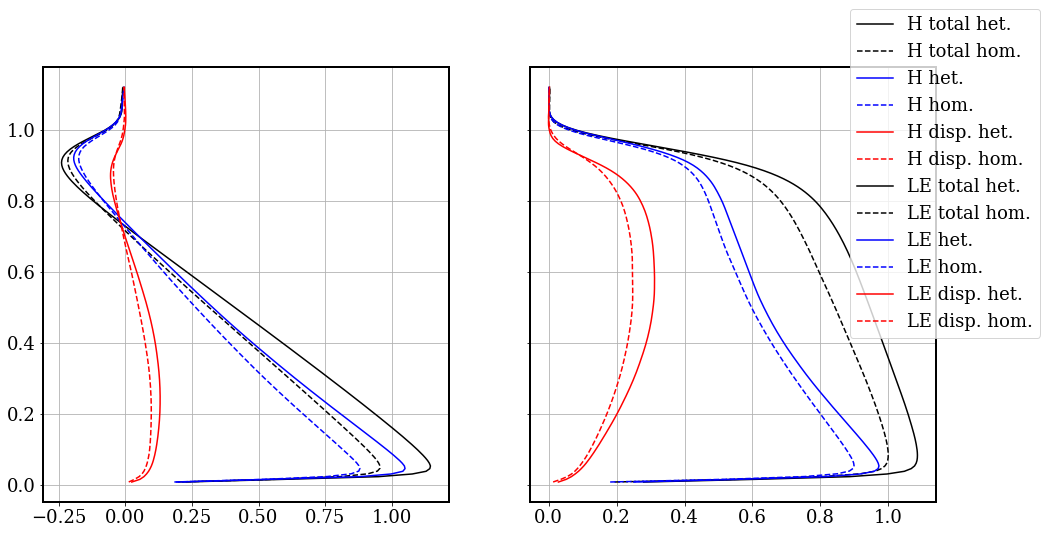

In [60]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)

#total fluxes
axes[0].plot(H_tot_1400/wtheta_surf_1400,z_plot_1400,'-',color='black',label='H total het.')
axes[0].plot(H_tot_1400_hom/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='black',label='H total hom.')

axes[1].plot(LE_tot_1400/wq_surf_1400,z_plot_1400,'-',color='black',label='LE total het.')
axes[1].plot(LE_tot_1400_hom/wq_surf_hom_1400,z_plot_1400_hom,'--',color='black',label='LE total hom.')

axes[0].plot(H_turb_1400/wtheta_surf_1400,z_plot_1400,'-',color='blue',label='H het.')
axes[0].plot(H_turb_1400_hom/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='blue',label='H hom.')
axes[0].plot(H_disp_1400/wtheta_surf_1400,z_plot_1400,'-',color='red',label='H disp. het.')
axes[0].plot(H_disp_1400_hom/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='red',label='H disp. hom.')

axes[1].plot(LE_turb_1400/wq_surf_1400,z_plot_1400,'-',color='blue',label='LE het.')
axes[1].plot(LE_turb_1400_hom/wq_surf_hom_1400,z_plot_1400_hom,'--',color='blue',label='LE hom.')
axes[1].plot(LE_disp_1400/wq_surf,z_plot_1400,'-',color='red',label='LE disp. het.')
axes[1].plot(LE_disp_1400_hom/wq_surf_hom_1400,z_plot_1400_hom,'--',color='red',label='LE disp. hom.')


fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()

for the ensemble mean fields:

In [48]:

H_tot_1400 = H_turb_1400+wtheta_ensemble_disp_1400
H_tot_1400_hom = H_turb_1400_hom+wtheta_ensemble_disp_1400_hom[1:]

LE_tot_1400 = LE_turb_1400+wq_ensemble_disp_1400
LE_tot_1400_hom = LE_turb_1400_hom+wq_ensemble_disp_1400_hom[1:]



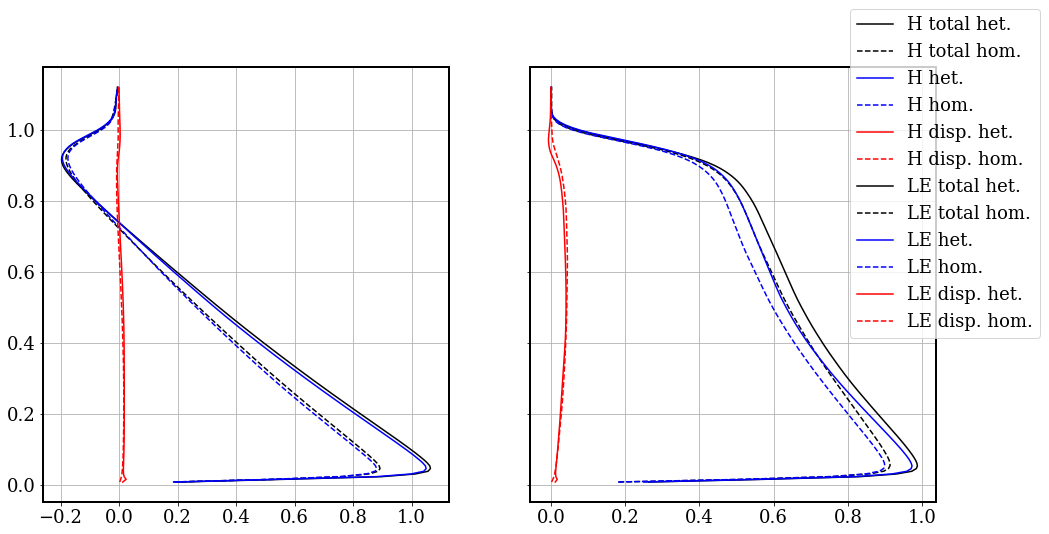

In [47]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)

#total fluxes
axes[0].plot(H_tot_1400/wtheta_surf_1400,z_plot_1400,'-',color='black',label='H total het.')
axes[0].plot(H_tot_1400_hom/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='black',label='H total hom.')

axes[1].plot(LE_tot_1400/wq_surf_1400,z_plot_1400,'-',color='black',label='LE total het.')
axes[1].plot(LE_tot_1400_hom/wq_surf_hom_1400,z_plot_1400_hom,'--',color='black',label='LE total hom.')

axes[0].plot(H_turb_1400/wtheta_surf_1400,z_plot_1400,'-',color='blue',label='H het.')
axes[0].plot(H_turb_1400_hom/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='blue',label='H hom.')
axes[0].plot(wtheta_ensemble_disp_1400/wtheta_surf_1400,z_plot_1400,'-',color='red',label='H disp. het.')
axes[0].plot(wtheta_ensemble_disp_1400_hom[1:]/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='red',label='H disp. hom.')

axes[1].plot(LE_turb_1400/wq_surf_1400,z_plot_1400,'-',color='blue',label='LE het.')
axes[1].plot(LE_turb_1400_hom/wq_surf_hom_1400,z_plot_1400_hom,'--',color='blue',label='LE hom.')
axes[1].plot(wq_ensemble_disp_1400/wq_surf,z_plot_1400,'-',color='red',label='LE disp. het.')
axes[1].plot(wq_ensemble_disp_1400_hom[1:]/wq_surf_hom_1400,z_plot_1400_hom,'--',color='red',label='LE disp. hom.')


fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()

Their vertical variation is very similar and the magnitudes are very small ~ 1%

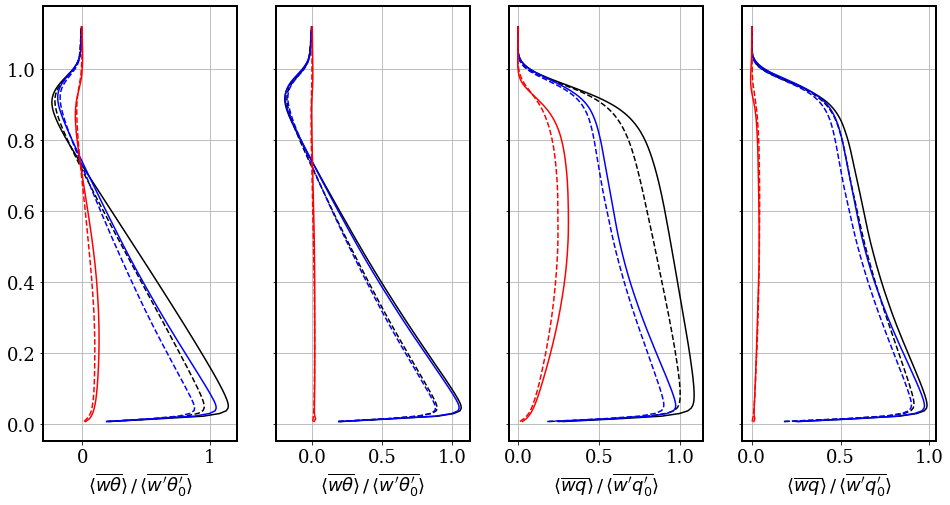

In [62]:


fig, (axes) = plt.subplots(1,4, figsize=(16,8), sharey=True)

axes[0].plot(H_tot_1400/wtheta_surf_1400,z_plot_1400,'-',color='black',label='H total het.')
axes[0].plot(H_tot_1400_hom/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='black',label='H total hom.')
axes[0].plot(H_turb_1400/wtheta_surf_1400,z_plot_1400,'-',color='blue',label='H het.')
axes[0].plot(H_turb_1400_hom/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='blue',label='H hom.')
axes[0].plot(H_disp_1400/wtheta_surf_1400,z_plot_1400,'-',color='red',label='H disp. het.')
axes[0].plot(H_disp_1400_hom/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='red',label='H disp. hom.')


#total fluxes (turb+het.)
axes[1].plot((H_turb_1400+wtheta_ensemble_disp_1400)/wtheta_surf_1400,z_plot_1400,'-',color='black',label='H total het.')
axes[1].plot((H_turb_1400_hom+wtheta_ensemble_disp_1400_hom[1:])/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='black',label='H total hom.')
#turbulent fluxes
axes[1].plot(H_turb_1400/wtheta_surf_1400,z_plot_1400,'-',color='blue',label='H het.')
axes[1].plot(H_turb_1400_hom/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='blue',label='H hom.')
#disp. fluxes
axes[1].plot(wtheta_ensemble_disp_1400/wtheta_surf_1400,z_plot_1400,'-',color='red',label='H disp. het.')
axes[1].plot(wtheta_ensemble_disp_1400_hom[1:]/wtheta_surf_hom_1400,z_plot_1400_hom,'--',color='red',label='H disp. hom.')


axes[2].plot(LE_tot_1400/wq_surf_1400,z_plot_1400,'-',color='black',label='LE total het.')
axes[2].plot(LE_tot_1400_hom/wq_surf_hom_1400,z_plot_1400_hom,'--',color='black',label='LE total hom.')
axes[2].plot(LE_turb_1400/wq_surf_1400,z_plot_1400,'-',color='blue',label='LE het.')
axes[2].plot(LE_turb_1400_hom/wq_surf_hom_1400,z_plot_1400_hom,'--',color='blue',label='LE hom.')
axes[2].plot(LE_disp_1400/wq_surf,z_plot_1400,'-',color='red',label='LE disp. het.')
axes[2].plot(LE_disp_1400_hom/wq_surf_hom_1400,z_plot_1400_hom,'--',color='red',label='LE disp. hom.')

#total fluxes (turb+het.)
axes[3].plot((LE_turb_1400+wq_ensemble_disp_1400)/wq_surf_1400,z_plot_1400,'-',color='black',label='H total het.')
axes[3].plot((LE_turb_1400_hom+wq_ensemble_disp_1400_hom[1:])/wq_surf_hom_1400,z_plot_1400_hom,'--',color='black',label='H total hom.')
#turbulent fluxes
axes[3].plot(LE_turb_1400/wq_surf_1400,z_plot_1400,'-',color='blue',label='H het.')
axes[3].plot(LE_turb_1400_hom/wq_surf_hom_1400,z_plot_1400_hom,'--',color='blue',label='H hom.')
#disp. fluxes
axes[3].plot(wq_ensemble_disp_1400/wq_surf_1400,z_plot_1400,'-',color='red',label='H disp. het.')
axes[3].plot(wq_ensemble_disp_1400_hom[1:]/wq_surf_hom_1400,z_plot_1400_hom,'--',color='red',label='H disp. hom.')

axes[0].set_xlabel(r"$ \langle \overline{w\theta} \rangle \, / \, \langle \overline{w'\theta_{0}'} \rangle$")
axes[1].set_xlabel(r"$ \langle \overline{w\theta} \rangle \, / \, \langle \overline{w'\theta_{0}'} \rangle$")
axes[2].set_xlabel(r"$ \langle \overline{wq} \rangle \, / \, \langle \overline{w'q_{0}'} \rangle$")
axes[3].set_xlabel(r"$ \langle \overline{wq} \rangle \, / \, \langle \overline{w'q_{0}'} \rangle$")

#fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()
axes[2].grid()
axes[3].grid()
plt.savefig('plots/domain_mean_flux_profiles/hom_vs_het_profiles_iop02_1400.png',dpi=300)

Plot the same for IOP03, 1200

In [26]:
IOP03_time_array[6]

'2019-09-24T12:00:00.000000000'

In [27]:
zi_iop03 = [  88.62130987,  141.84283359,  225.54037425,  322.57451548,
        396.33941635,  475.2585832 ,  592.48186233,  679.5148229 ,
        758.12848296,  849.92848296,  958.90627311, 1030.6234217 ]
zi_iop03_hom = [ 80.69513477, 126.33890844, 184.98307418, 279.36109601,
       363.49589218, 491.99541546, 652.15589218, 750.80264201,
       826.63606594, 885.59620405, 933.9983738 , 977.12602361]

In [102]:
#calculate turbulent and dispersive fluxes for all ensemble members for 1200
wtheta_turb_list_iop03 = []
wq_turb_list_iop03 = []

wtheta_disp_list_iop03 = []
wq_disp_list_iop03 = []

time_step = IOP03_time_array[6]
for member in np.arange(0,8):
    ds = open_concat_member_files(member,'DATA_3D_AV_NETCDF_N02slice','iop03').sel(time=time_step)
    #subset for the sub-domain
    ds1 = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop03[6]+200),zw_3d=slice(None,zi_iop03[6]+200))

    wtheta_turb = calculate_turb_flux(ds1)['wtheta_turb_energy'].mean('x').mean('y').compute()
    wq_turb = calculate_turb_flux(ds1)['wq_turb_energy'].mean('x').mean('y').compute()
    
    wtheta_disp, wq_disp = calc_disp_flux(ds1)

    wtheta_turb_list_iop03.append(wtheta_turb)
    wq_turb_list_iop03.append(wq_turb)
    
    wtheta_disp_list_iop03.append(wtheta_disp)
    wq_disp_list_iop03.append(wq_disp)

wtheta_turb_iop03 = xr.concat(wtheta_turb_list_iop03,dim='ensemble')
wq_turb_iop03 = xr.concat(wq_turb_list_iop03,dim='ensemble')

wtheta_disp_iop03 = xr.concat(wtheta_disp_list_iop03,dim='ensemble')
wq_disp_iop03 = xr.concat(wq_disp_list_iop03,dim='ensemble')

['01.ches_IOP3.14592', '02.ches_IOP3.660', '03.ches_IOP3.19260', '04.ches_IOP3.22682', '05.ches_IOP3.31133', '06.ches_IOP3.29659', '07.ches_IOP3.19900', '08.ches_IOP3.24658', '09.ches_IOP3.23660', '10.ches_IOP3.5654', '11.ches_IOP3.1905', '12.ches_IOP3.27019', '13.ches_IOP3.9399', '14.ches_IOP3.5300', '15.ches_IOP3.17284', '16.ches_IOP3.4936', '17.ches_IOP3.29670', '18.ches_IOP3.8982']
Member 0 finished collecting data
Done with member 0  Time elapsed  9.111616980284452 seconds
[########################################] | 100% Completed | 896.45 ms
[########################################] | 100% Completed | 706.47 ms
[########################################] | 100% Completed | 812.38 ms
[########################################] | 100% Completed | 706.11 ms
['01.ches_IOP3.19457', '02.ches_IOP3.8195', '03.ches_IOP3.189', '04.ches_IOP3.4230', '05.ches_IOP3.25038', '06.ches_IOP3.10580', '07.ches_IOP3.3465', '08.ches_IOP3.7653', '09. ches_IOP3.14688']
Member 1 finished collecting data
D

In [98]:
#calculate turbulent and dispersive fluxes for all ensemble members for 1100
wtheta_turb_list_iop03_hom = []
wq_turb_list_iop03_hom = []

wtheta_disp_list_iop03_hom = []
wq_disp_list_iop03_hom = []

time_step = IOP03_time_array[6]
for member in np.arange(1,9):
    ds = open_concat_member_files_hom(member,'DATA_3D_AV_NETCDF_N02slice','iop03').sel(time=time_step)
    #subset for the sub-domain
    ds1 = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop03_hom[6]+200),zw_3d=slice(None,zi_iop03_hom[6]+200))

    wtheta_turb = calculate_turb_flux(ds1)['wtheta_turb_energy'].mean('x').mean('y').compute()
    wq_turb = calculate_turb_flux(ds1)['wq_turb_energy'].mean('x').mean('y').compute()
    
    wtheta_disp, wq_disp = calc_disp_flux(ds1)

    wtheta_turb_list_iop03_hom.append(wtheta_turb)
    wq_turb_list_iop03_hom.append(wq_turb)
    
    wtheta_disp_list_iop03_hom.append(wtheta_disp)
    wq_disp_list_iop03_hom.append(wq_disp)

wtheta_turb_iop03_hom = xr.concat(wtheta_turb_list_iop03_hom,dim='ensemble')
wq_turb_iop03_hom = xr.concat(wq_turb_list_iop03_hom,dim='ensemble')

wtheta_disp_iop03_hom = xr.concat(wtheta_disp_list_iop03_hom,dim='ensemble')
wq_disp_iop03_hom = xr.concat(wq_disp_list_iop03_hom,dim='ensemble')

['0.ches_IOP3_parent_child1_hom1.12767', '1.ches_IOP3_parent_child1_hom1.14954']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.5233183614909649 seconds
[########################################] | 100% Completed | 3.63 sms
[########################################] | 100% Completed | 1.81 sms
[########################################] | 100% Completed | 806.22 ms
[########################################] | 100% Completed | 1.21 sms
['0.ches_IOP3_parent_child1_hom2.24067', '1.ches_IOP3_parent_child1_hom2.6737']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2455137073993683 seconds
[########################################] | 100% Completed | 807.20 ms
[########################################] | 100% Completed | 705.84 ms
[########################################] | 100% Completed | 806.81 ms
[########################################] | 100% Completed | 1.32 sms
['0.ches_IOP3_parent_child1_hom3.21914', '1.ches_IOP3_parent_child1_hom3.9923

Het. induced values:

In [88]:
time_step = IOP03_time_array[6]
#subset for the sub-domain

#het. runs
ds1 = ensemble_ds_iop03_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop03[6]+200),zw_3d=slice(None,zi_iop03[6]+200),time=time_step).mean('ensemble')

wtheta_ensemble_disp_iop03, wq_ensemble_disp_iop03 = calc_disp_flux(ds1)


[########################################] | 100% Completed | 221.35 s
[########################################] | 100% Completed | 194.43 s


In [28]:
time_step = IOP03_time_array[10]
#subset for the sub-domain

#het. runs
ds1 = ensemble_ds_iop03_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop03[10]+200),zw_3d=slice(None,zi_iop03[10]+200),time=time_step).mean('ensemble')

wtheta_ensemble_disp_iop03, wq_ensemble_disp_iop03 = calc_disp_flux(ds1)


[########################################] | 100% Completed | 150.98 s
[########################################] | 100% Completed | 126.15 s


In [89]:
#hom. runs

#subset for the sub-domain
ds1 = ensemble_ds_iop03_N02_hom.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop03_hom[6]+200),zw_3d=slice(None,zi_iop03_hom[6]+200),time=time_step).mean('ensemble')

wtheta_ensemble_disp_iop03_hom, wq_ensemble_disp_iop03_hom = calc_disp_flux(ds1)


[########################################] | 100% Completed | 95.81 s
[########################################] | 100% Completed | 167.89 s


In [31]:
#hom. runs
#1400
#subset for the sub-domain
ds1 = ensemble_ds_iop03_N02_hom.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop03_hom[10]+200),zw_3d=slice(None,zi_iop03_hom[10]+200),time=time_step).mean('ensemble')

wtheta_ensemble_disp_iop03_hom, wq_ensemble_disp_iop03_hom = calc_disp_flux(ds1)


[########################################] | 100% Completed | 64.34 s
[########################################] | 100% Completed | 70.70 s


In [29]:
wtheta_iop03 = profile_N02_member_2_ds_iop03.resample(time='30T').mean()['wtheta']
wtheta_iop03_hom = profile_N02_member_2_ds_iop03_hom.resample(time='30T').mean()['wtheta']

wq_iop03 = profile_N02_member_2_ds_iop03.resample(time='30T').mean()['wq']
wq_iop03_hom = profile_N02_member_2_ds_iop03_hom.resample(time='30T').mean()['wq']


In [31]:
#print((wtheta_hom.sel(time=IOP02_time_array[4])[0]*(1.17*1005)).compute().values)
time_index = 6
print(IOP03_time_array[time_index])
#print(wtheta.sel(time=IOP02_time_array[4])[3].compute().values)
wtheta_surf_iop03 = wtheta_iop03.sel(time=IOP03_time_array[time_index])[3].compute().values
wtheta_surf_hom_iop03 = (wtheta_iop03_hom.sel(time=IOP03_time_array[time_index])[0]*(1.17*1005)).compute().values

wq_surf_iop03 = wq_iop03.sel(time=IOP03_time_array[time_index])[3].compute().values
wq_surf_hom_iop03 = (wq_iop03_hom.sel(time=IOP03_time_array[time_index])[0]*(1.17*1000*2500)).compute().values


2019-09-24T12:00:00.000000000
[########################################] | 100% Completed | 833.10 ms
[########################################] | 100% Completed | 201.49 ms
[########################################] | 100% Completed | 101.14 ms
[########################################] | 100% Completed | 101.07 ms


In [30]:
#print((wtheta_hom.sel(time=IOP02_time_array[4])[0]*(1.17*1005)).compute().values)
time_index = 10
print(IOP03_time_array[time_index])
#print(wtheta.sel(time=IOP02_time_array[4])[3].compute().values)
wtheta_surf_iop03 = wtheta_iop03.sel(time=IOP03_time_array[time_index])[3].compute().values
wtheta_surf_hom_iop03 = (wtheta_iop03_hom.sel(time=IOP03_time_array[time_index])[0]*(1.17*1005)).compute().values

wq_surf_iop03 = wq_iop03.sel(time=IOP03_time_array[time_index])[3].compute().values
wq_surf_hom_iop03 = (wq_iop03_hom.sel(time=IOP03_time_array[time_index])[0]*(1.17*1000*2500)).compute().values


2019-09-24T14:00:00.000000000
[########################################] | 100% Completed | 303.26 ms
[########################################] | 100% Completed | 204.46 ms
[########################################] | 100% Completed | 101.19 ms
[########################################] | 100% Completed | 101.18 ms


In [32]:
z_plot_iop03 = wtheta_ensemble_disp_iop03.zw_3d/zi_iop03[6]
z_plot_iop03_hom = wtheta_ensemble_disp_iop03_hom.zw_3d[1:]/zi_iop03_hom[6]

In [108]:
H_turb_iop03 = wtheta_turb_iop03.mean('ensemble').values
LE_turb_iop03 = wq_turb_iop03.mean('ensemble').values

H_disp_iop03 = wtheta_disp_iop03.mean('ensemble').values
LE_disp_iop03 = wq_disp_iop03.mean('ensemble').values

H_turb_iop03_hom = wtheta_turb_iop03_hom.mean('ensemble').values[1:]
LE_turb_iop03_hom = wq_turb_iop03_hom.mean('ensemble').values[1:]

H_disp_iop03_hom = wtheta_disp_iop03_hom.mean('ensemble').values[1:]
LE_disp_iop03_hom = wq_disp_iop03_hom.mean('ensemble').values[1:]

H_tot_iop03 = H_turb_iop03+H_disp_iop03
H_tot_iop03_hom = H_turb_iop03_hom+H_disp_iop03_hom

LE_tot_iop03 = LE_turb_iop03+LE_disp_iop03
LE_tot_iop03_hom = LE_turb_iop03_hom+LE_disp_iop03_hom



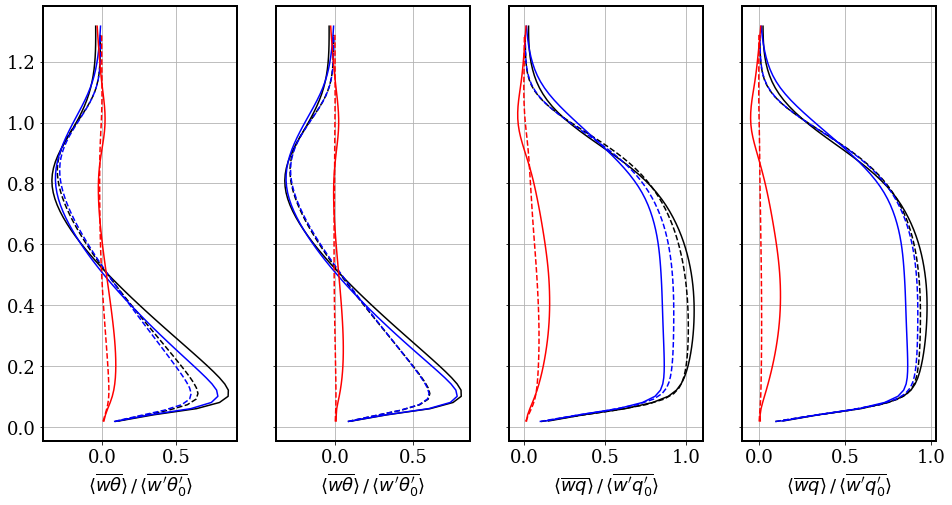

In [112]:

fig, (axes) = plt.subplots(1,4, figsize=(16,8), sharey=True)

axes[0].plot(H_tot_iop03/wtheta_surf_iop03,z_plot_iop03,'-',color='black',label='H total het.')
axes[0].plot(H_tot_iop03_hom/wtheta_surf_hom_iop03,z_plot_iop03_hom,'--',color='black',label='H total hom.')
axes[0].plot(H_turb_iop03/wtheta_surf_iop03,z_plot_iop03,'-',color='blue',label='H het.')
axes[0].plot(H_turb_iop03_hom/wtheta_surf_hom_iop03,z_plot_iop03_hom,'--',color='blue',label='H hom.')
axes[0].plot(H_disp_iop03/wtheta_surf_iop03,z_plot_iop03,'-',color='red',label='H disp. het.')
axes[0].plot(H_disp_iop03_hom/wtheta_surf_hom_iop03,z_plot_iop03_hom,'--',color='red',label='H disp. hom.')


#total fluxes (turb+het.)
axes[1].plot((H_turb_iop03+wtheta_ensemble_disp_iop03)/wtheta_surf_iop03,z_plot_iop03,'-',color='black',label='H total het.')
axes[1].plot((H_turb_iop03_hom+wtheta_ensemble_disp_iop03_hom[1:])/wtheta_surf_hom_iop03,z_plot_iop03_hom,'--',color='black',label='H total hom.')
#turbulent fluxes
axes[1].plot(H_turb_iop03/wtheta_surf_iop03,z_plot_iop03,'-',color='blue',label='H het.')
axes[1].plot(H_turb_iop03_hom/wtheta_surf_hom_iop03,z_plot_iop03_hom,'--',color='blue',label='H hom.')
#disp. fluxes
axes[1].plot(wtheta_ensemble_disp_iop03/wtheta_surf_iop03,z_plot_iop03,'-',color='red',label='H disp. het.')
axes[1].plot(wtheta_ensemble_disp_iop03_hom[1:]/wtheta_surf_hom_iop03,z_plot_iop03_hom,'--',color='red',label='H disp. hom.')


axes[2].plot(LE_tot_iop03/wq_surf_iop03,z_plot_iop03,'-',color='black',label='LE total het.')
axes[2].plot(LE_tot_iop03_hom/wq_surf_hom_iop03,z_plot_iop03_hom,'--',color='black',label='LE total hom.')
axes[2].plot(LE_turb_iop03/wq_surf_iop03,z_plot_iop03,'-',color='blue',label='LE het.')
axes[2].plot(LE_turb_iop03_hom/wq_surf_hom_iop03,z_plot_iop03_hom,'--',color='blue',label='LE hom.')
axes[2].plot(LE_disp_iop03/wq_surf,z_plot_iop03,'-',color='red',label='LE disp. het.')
axes[2].plot(LE_disp_iop03_hom/wq_surf_hom_iop03,z_plot_iop03_hom,'--',color='red',label='LE disp. hom.')

#total fluxes (turb+het.)
axes[3].plot((LE_turb_iop03+wq_ensemble_disp_iop03)/wq_surf_iop03,z_plot_iop03,'-',color='black',label='H total het.')
axes[3].plot((LE_turb_iop03_hom+wq_ensemble_disp_iop03_hom[1:])/wq_surf_hom_iop03,z_plot_iop03_hom,'--',color='black',label='H total hom.')
#turbulent fluxes
axes[3].plot(LE_turb_iop03/wq_surf_iop03,z_plot_iop03,'-',color='blue',label='H het.')
axes[3].plot(LE_turb_iop03_hom/wq_surf_hom_iop03,z_plot_iop03_hom,'--',color='blue',label='H hom.')
#disp. fluxes
axes[3].plot(wq_ensemble_disp_iop03/wq_surf_iop03,z_plot_iop03,'-',color='red',label='H disp. het.')
axes[3].plot(wq_ensemble_disp_iop03_hom[1:]/wq_surf_hom_iop03,z_plot_iop03_hom,'--',color='red',label='H disp. hom.')


axes[0].set_xlabel(r"$ \langle \overline{w\theta} \rangle \, / \, \langle \overline{w'\theta_{0}'} \rangle$")
axes[1].set_xlabel(r"$ \langle \overline{w\theta} \rangle \, / \, \langle \overline{w'\theta_{0}'} \rangle$")
axes[2].set_xlabel(r"$ \langle \overline{wq} \rangle \, / \, \langle \overline{w'q_{0}'} \rangle$")
axes[3].set_xlabel(r"$ \langle \overline{wq} \rangle \, / \, \langle \overline{w'q_{0}'} \rangle$")

#fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()
axes[2].grid()
axes[3].grid()
plt.savefig('plots/domain_mean_flux_profiles/hom_vs_het_profiles_iop03_1200.png',dpi=300)

calculate and plot the horizontal dispersive fluxes:

In [24]:
IOP03_time_array[6]

'2019-09-24T12:00:00.000000000'

In [36]:
time_step = IOP03_time_array[6]
#subset for the sub-domain

#het. runs
ds1 = ensemble_ds_iop03_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop03[6]+200),zw_3d=slice(None,zi_iop03[6]+200),time=time_step).mean('ensemble')

vtheta_ensemble_disp_iop03, vq_ensemble_disp_iop03 = calc_hzntl_disp_flux(ds1,'v')


[########################################] | 100% Completed | 190.01 s
[########################################] | 100% Completed | 194.92 s


In [37]:
#hom. runs

#subset for the sub-domain
ds1 = ensemble_ds_iop03_N02_hom.isel(x=slice(x_min,x_max),y=slice(y_min,y_max)).sel(zu_3d=slice(None,zi_iop03_hom[6]+200),zw_3d=slice(None,zi_iop03_hom[6]+200),time=time_step).mean('ensemble')

vtheta_ensemble_disp_iop03_hom, vq_ensemble_disp_iop03_hom = calc_hzntl_disp_flux(ds1,'v')


[########################################] | 100% Completed | 148.03 s
[########################################] | 100% Completed | 161.12 s


In [29]:
z_plot_iop03 = vtheta_ensemble_disp_iop03.zw_3d/zi_iop03[6]
z_plot_iop03_hom = vtheta_ensemble_disp_iop03_hom.zw_3d[1:]/zi_iop03_hom[6]

In [40]:
vtheta_ensemble_disp_iop03.values

array([         nan, -78.27048   , -65.58756   , -33.799732  ,
       -26.568739  , -24.054193  , -22.332703  , -20.475927  ,
       -18.42212   , -16.159538  , -13.681786  , -11.000137  ,
        -8.126898  ,  -5.054034  ,  -1.7713001 ,   1.7109022 ,
         5.393894  ,   9.274952  ,  13.364201  ,  17.669863  ,
        22.199524  ,  26.932198  ,  31.861862  ,  36.990643  ,
        42.276764  ,  47.63238   ,  52.956764  ,  58.13838   ,
        63.09085   ,  67.67761   ,  71.75172   ,  75.153755  ,
        77.77722   ,  79.58291   ,  80.557976  ,  80.65628   ,
        79.88413   ,  78.31005   ,  76.033775  ,  73.12214   ,
        69.617805  ,  65.46405   ,  60.55596   ,  54.824078  ,
        48.193054  ,  40.75418   ,  32.72324   ,  24.282402  ,
        15.71526   ,   7.3294067 ,  -0.63826424,  -8.00993   ,
       -14.659005  , -20.570248  , -25.81704   , -30.520332  ,
       -34.75649   , -38.61165   , -42.091713  , -45.16567   ,
       -47.79978   , -50.018433  , -51.84773   , -53.30

In [41]:
H_disp_iop03 = vtheta_ensemble_disp_iop03.values
LE_disp_iop03 = vq_ensemble_disp_iop03.values

H_disp_iop03_hom = vtheta_ensemble_disp_iop03_hom.values[1:]
LE_disp_iop03_hom = vq_ensemble_disp_iop03_hom.values[1:]


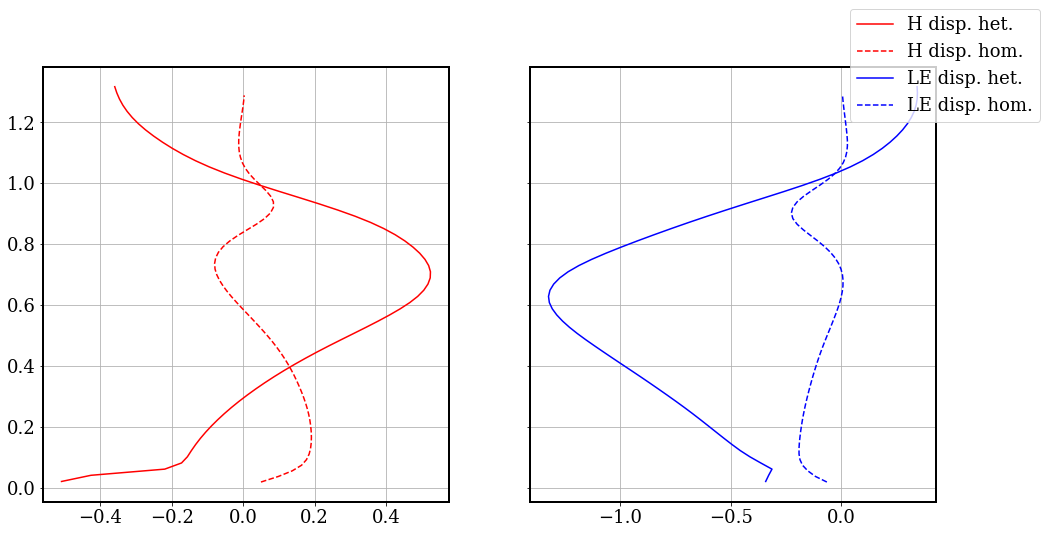

In [42]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)

#total fluxes
axes[0].plot(H_disp_iop03/wtheta_surf_iop03,z_plot_iop03,'-',color='red',label='H disp. het.')
axes[0].plot(H_disp_iop03_hom/wtheta_surf_hom_iop03,z_plot_iop03_hom,'--',color='red',label='H disp. hom.')

axes[1].plot(LE_disp_iop03/wq_surf_iop03,z_plot_iop03,'-',color='blue',label='LE disp. het.')
axes[1].plot(LE_disp_iop03_hom/wq_surf_hom_iop03,z_plot_iop03_hom,'--',color='blue',label='LE disp. hom.')


fig.legend()
# ax.set_ylim([30,900])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()

just checking the hi fluxes at 1400:

In [33]:
H_disp_iop03 = wtheta_ensemble_disp_iop03.values
LE_disp_iop03 = wq_ensemble_disp_iop03.values

H_disp_iop03_hom = wtheta_ensemble_disp_iop03_hom.values[1:]
LE_disp_iop03_hom = wq_ensemble_disp_iop03_hom.values[1:]


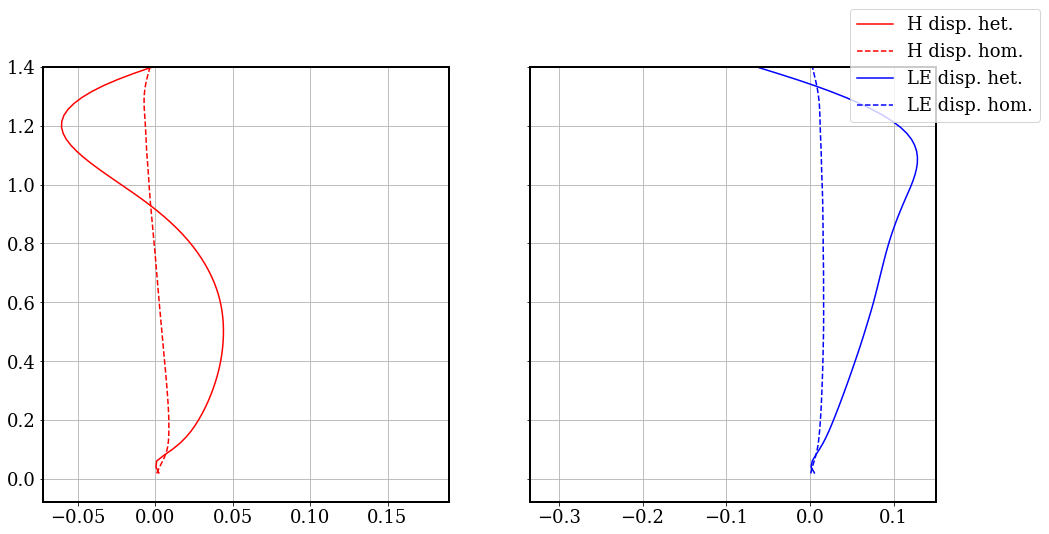

In [37]:
fig, axes = plt.subplots(1,2,figsize=(16,8),sharey=True)

#total fluxes
axes[0].plot(H_disp_iop03/wtheta_surf_iop03,z_plot_iop03,'-',color='red',label='H disp. het.')
axes[0].plot(H_disp_iop03_hom/wtheta_surf_hom_iop03,z_plot_iop03_hom,'--',color='red',label='H disp. hom.')

axes[1].plot(LE_disp_iop03/wq_surf_iop03,z_plot_iop03,'-',color='blue',label='LE disp. het.')
axes[1].plot(LE_disp_iop03_hom/wq_surf_hom_iop03,z_plot_iop03_hom,'--',color='blue',label='LE disp. hom.')


fig.legend()
axes[0].set_ylim([None,1.4])
axes[1].set_ylim([None,1.4])
# ax.set_xlim([-0.25,2.4])

#wtheta_turb_profiledata_hom*(1.17*1005)

axes[0].grid()
axes[1].grid()

Save all the data as np arrays:


In [113]:
#iop02, 1100
np.save('work/hom_vs_het/H_turb',H_turb)
np.save('work/hom_vs_het/H_disp',H_disp)
np.save('work/hom_vs_het/LE_disp',LE_disp)
np.save('work/hom_vs_het/H_turb_hom',H_turb_hom)
np.save('work/hom_vs_het/LE_turb_hom',LE_turb_hom)
np.save('work/hom_vs_het/H_disp_hom',H_disp_hom)
np.save('work/hom_vs_het/LE_disp_hom',LE_disp_hom)
np.save('work/hom_vs_het/H_tot',H_tot)
np.save('work/hom_vs_het/H_tot_hom',H_tot_hom)
np.save('work/hom_vs_het/LE_tot',LE_tot)
np.save('work/hom_vs_het/LE_tot_hom',LE_tot_hom)
np.save('work/hom_vs_het/wtheta_ensemble_disp',wtheta_ensemble_disp)
np.save('work/hom_vs_het/wtheta_ensemble_disp_hom',wtheta_ensemble_disp_hom)
np.save('work/hom_vs_het/wq_ensemble_disp',wq_ensemble_disp)
np.save('work/hom_vs_het/wq_ensemble_disp_hom',wq_ensemble_disp_hom)
np.save('work/hom_vs_het/wtheta_surf',wtheta_surf)
np.save('work/hom_vs_het/wtheta_surf_hom',wtheta_surf_hom)
np.save('work/hom_vs_het/wq_surf',wq_surf)
np.save('work/hom_vs_het/wq_surf_hom',wq_surf_hom)
np.save('work/hom_vs_het/z_plot',z_plot)
np.save('work/hom_vs_het/z_plot_hom',z_plot_hom)
 




In [121]:
#iop02, 1400
np.save('work/hom_vs_het/H_turb_1400',H_turb_1400)
np.save('work/hom_vs_het/H_disp_1400',H_disp_1400)
np.save('work/hom_vs_het/LE_disp_1400',LE_disp_1400)
np.save('work/hom_vs_het/H_turb_1400_hom',H_turb_1400_hom)
np.save('work/hom_vs_het/LE_1400_hom',LE_turb_1400_hom)
np.save('work/hom_vs_het/H_disp_1400_hom',H_disp_1400_hom)
np.save('work/hom_vs_het/LE_disp_1400_hom',LE_disp_1400_hom)
np.save('work/hom_vs_het/H_tot_1400',H_tot_1400)
np.save('work/hom_vs_het/H_tot_1400_hom',H_tot_1400_hom)
np.save('work/hom_vs_het/LE_tot_1400',LE_tot_1400)
np.save('work/hom_vs_het/LE_tot_1400_hom',LE_tot_1400_hom)
np.save('work/hom_vs_het/wtheta_ensemble_disp_1400',wtheta_ensemble_disp_1400)
np.save('work/hom_vs_het/wtheta_ensemble_disp_1400_hom',wtheta_ensemble_disp_1400_hom)
np.save('work/hom_vs_het/wq_ensemble_disp_1400',wq_ensemble_disp_1400)
np.save('work/hom_vs_het/wq_ensemble_disp_1400_hom',wq_ensemble_disp_1400_hom)
np.save('work/hom_vs_het/wtheta_surf_1400',wtheta_surf_1400)
np.save('work/hom_vs_het/wtheta_surf_hom_1400',wtheta_surf_hom_1400)
np.save('work/hom_vs_het/wq_surf_1400',wq_surf_1400)
np.save('work/hom_vs_het/wq_surf_hom_1400',wq_surf_hom_1400)
np.save('work/hom_vs_het/z_plot_1400',z_plot_1400)
np.save('work/hom_vs_het/z_plot_1400_hom',z_plot_1400_hom)

In [ ]:
#iop03, 1200
np.save('work/hom_vs_het/H_turb_iop03',H_turb_iop03)
np.save('work/hom_vs_het/H_disp_iop03',H_disp_iop03)
np.save('work/hom_vs_het/LE_disp_iop03',LE_disp_iop03)
np.save('work/hom_vs_het/H_turb_iop03_hom',H_turb_iop03_hom)
np.save('work/hom_vs_het/LE_turb_iop03_hom',LE_turb_iop03_hom)
np.save('work/hom_vs_het/H_disp_iop03_hom',H_disp_iop03_hom)
np.save('work/hom_vs_het/LE_disp_iop03_hom',LE_disp_iop03_hom)
np.save('work/hom_vs_het/H_tot_iop03',H_tot_iop03)
np.save('work/hom_vs_het/H_tot_iop03_hom',H_tot_iop03_hom)
np.save('work/hom_vs_het/LE_tot_iop03',LE_tot_iop03)
np.save('work/hom_vs_het/LE_tot_iop03_hom',LE_tot_iop03_hom)
np.save('work/hom_vs_het/wtheta_ensemble_disp_iop03',wtheta_ensemble_disp_iop03)
np.save('work/hom_vs_het/wtheta_ensemble_disp_iop03_hom',wtheta_ensemble_disp_iop03_hom)
np.save('work/hom_vs_het/wq_ensemble_disp_iop03',wq_ensemble_disp_iop03)
np.save('work/hom_vs_het/wq_ensemble_disp_iop03_hom',wq_ensemble_disp_iop03_hom)
np.save('work/hom_vs_het/wtheta_surf',wtheta_surf)
np.save('work/hom_vs_het/wtheta_surf_hom',wtheta_surf_hom)
np.save('work/hom_vs_het/wq_surf',wq_surf)
np.save('work/hom_vs_het/wq_surf_hom',wq_surf_hom)
np.save('work/hom_vs_het/z_plot',z_plot)
np.save('work/hom_vs_het/z_plot_hom',z_plot_hom)

##### Initial scratch codes

In [ ]:
profile_subset = profile_N02_member_2_ds_iop03.sel(time=slice('2019-09-24T11:00:00.000000000','2019-09-24T12:30:00.000000000')).resample(time='30T').mean()


surface_fluxes_H = (profile_subset.wtheta.sel(zwtheta=36)).values
surface_fluxes_LE = (profile_subset.wq.sel(zwq=36)).values


[########################################] | 100% Completed | 117.43 ms
[########################################] | 100% Completed | 101.31 ms


In [ ]:
ds = ensemble_ds_iop03_N02.isel(x=slice(449-167,449+167),y=slice(503-167,503+167)).sel(zw_3d = slice (10,None),time='2019-09-24T12:00:00.000000000').mean('ensemble')

ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

w_disp = ds['w'] - ds['w'].mean('x').mean('y')

theta_disp = ds['theta_interpolated'] - ds['theta_interpolated'].mean('x').mean('y')
q_disp = ds['q_interpolated'] - ds['q_interpolated'].mean('x').mean('y')

wtheta_disp = (w_disp * theta_disp).mean('x').mean('y').compute()
wq_disp = (w_disp * q_disp).mean('x').mean('y').compute()


[########################################] | 100% Completed | 109.55 s
[########################################] | 100% Completed | 149.59 s


[########################################] | 100% Completed | 101.63 ms
[########################################] | 100% Completed | 201.94 ms


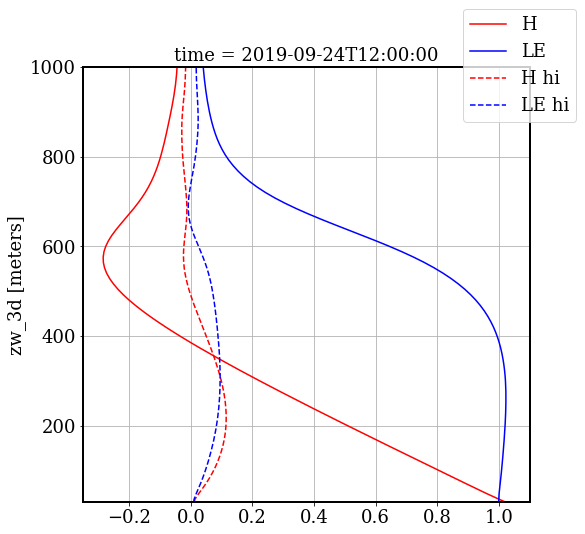

In [ ]:
time_step = '2019-09-24T12:00:00.000000000'

profile_subset = profile_N02_member_2_ds_iop03.resample(time='30T').mean().sel(time=time_step)

fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)

(profile_subset.wtheta/surface_fluxes_H[2]).plot(label = "H",y='zwtheta', color='red',ax=ax)
(profile_subset.wq/surface_fluxes_LE[2]).plot(label = "LE",y='zwq', color='blue',ax=ax)

# (wtheta_disp/surface_fluxes_H[0]).plot(y='zw_3d',linestyle='--',color='red',ax=ax, label= 'H hi' )
# (wq_disp/surface_fluxes_LE[0]).plot(y='zw_3d',linestyle='--',color='blue',ax=ax, label= 'LE hi' )

(wtheta_disp*1.17*1005/surface_fluxes_H[2]).plot(y='zw_3d',linestyle='--',color='red',ax=ax, label= 'H hi' )
(wq_disp*1.17*1000*2501/surface_fluxes_LE[2]).plot(y='zw_3d',linestyle='--',color='blue',ax=ax,label='LE hi')

# fig.legend()
# ax.set_ylim([30,1700])
# ax.set_xlim([-0.25,1.1])
# plt.grid()
fig.legend()
ax.set_ylim([30,1000])
ax.set_xlim([-0.35,1.1])
plt.grid()

[########################################] | 100% Completed | 101.85 ms
[########################################] | 100% Completed | 101.26 ms


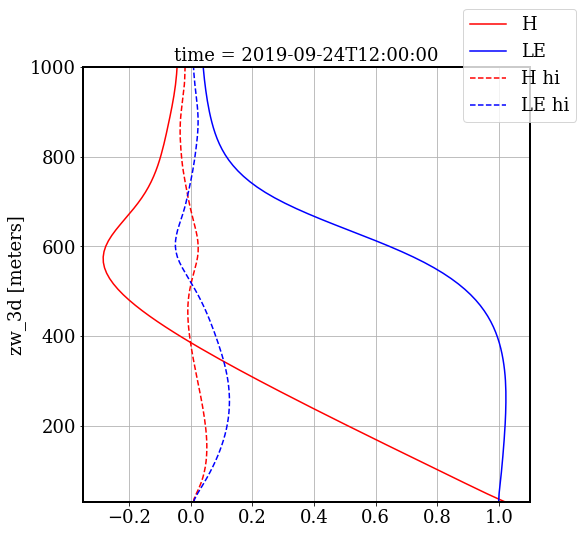

In [12]:
time_step = '2019-09-24T12:00:00.000000000'

profile_subset = profile_N02_member_2_ds_iop03.resample(time='30T').mean().sel(time=time_step)

fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)

(profile_subset.wtheta/surface_fluxes_H[2]).plot(label = "H",y='zwtheta', color='red',ax=ax)
(profile_subset.wq/surface_fluxes_LE[2]).plot(label = "LE",y='zwq', color='blue',ax=ax)

# (wtheta_disp/surface_fluxes_H[0]).plot(y='zw_3d',linestyle='--',color='red',ax=ax, label= 'H hi' )
# (wq_disp/surface_fluxes_LE[0]).plot(y='zw_3d',linestyle='--',color='blue',ax=ax, label= 'LE hi' )

(wtheta_disp*1.17*1005/surface_fluxes_H[2]).plot(y='zw_3d',linestyle='--',color='red',ax=ax, label= 'H hi' )
(wq_disp*1.17*1000*2501/surface_fluxes_LE[2]).plot(y='zw_3d',linestyle='--',color='blue',ax=ax,label='LE hi')

# fig.legend()
# ax.set_ylim([30,1700])
# ax.set_xlim([-0.25,1.1])
# plt.grid()
fig.legend()
ax.set_ylim([30,1000])
ax.set_xlim([-0.35,1.1])
plt.grid()